# **East Africa drought study - exploratory analysis**

**Data sources:**

- CHIRPS 0.5deg gridded daily precipitation data, augmented with CenTrends (0.1deg resolution, monthly data)
- National shapefile: https://data.humdata.org/dataset/greater-horn-of-africa-countries
- Gridded elevation data: https://download.gebco.net/
- GPCC drought indices: https://opendata.dwd.de/climate_environment/GPCC/html/gpcc_di_doi_download.html, https://opendata.dwd.de/climate_environment/GPCC/html/gpcc_di_v_1-1_doi_download.html


In [2]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *
from wwa_nonstationary_fitting import *

# for SPEI fitting
import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo") 

proj_kw = {"projection" : cartopy.crs.PlateCarree()}

def linear_trend(da): return da.assign_coords(time = da.time.dt.year).dropna("time", "all").polyfit("time", 1).polyfit_coefficients.sel(degree = 1).rename("Linear trend")

---
## **Pre-processing**

### **Gridded data**

In [26]:
# get monthly CHIRPS data over same region as centrends (will need a larger area for spatial pattern, but this is better to work with)
chirps = xr.open_mfdataset("../../Data/chirps_05/*.nc").sel(longitude = slice(33,51.5), latitude = slice(-5,15))
chirps_m = chirps.resample(time = "MS").sum(skipna = False).assign_attrs(long_name = "Monthly precip", units = "mm")
chirps_m.to_netcdf("data/chirps05_monthly.nc")

In [6]:
# daily data at coarser resolution - used to get seasonal cycle
chirps = xr.open_mfdataset("../../Data/chirps_25/*.nc").sel(longitude = slice(33,51.5), latitude = slice(-5,15))
chirps.to_netcdf("data/chirps25_daily.nc")

In [68]:
cpc = xr.open_mfdataset("../../Data/cpc/precip.*.nc").sel(lon = slice(33,52), lat = slice(15,-5)).resample(time = "MS").sum().assign_attrs(long_name = "Monthly precip", units = "mm")
cpc.to_netcdf("data/cpc_monthly.nc")

# keep tmin, tmax at daily resolution for more accurate estimate of PET
[xr.open_mfdataset("../../Data/cpc/"+varnm+".*.nc").sel(lon = slice(33,52), lat = slice(15,-5)).to_netcdf("data/cpc_"+varnm+".nc") for varnm in ["tmin", "tmax"]]

In [120]:
# monthly mean temperature also needed
tas = (xr.open_dataset("data/cpc_tmax.nc").tmax + xr.open_dataset("data/cpc_tmin.nc").tmin) / 2
tas.resample(time = "MS").mean().rename("tas").to_netcdf("data/cpc_tas.nc")

In [46]:
# # extract necessary data from MSWEP daily files - slow, try to avoid running again
# for y in range(1979, 2021):
#     ds = xr.open_mfdataset("/home/clair/Data/mswep_past/"+str(y)+"*.nc").sel(lon = slice(33,51.5), lat = slice(15,-5)).resample(time = "MS").sum(skipna = False).assign_attrs(long_name = "Monthly precip", units = "mm")
#     ds.to_netcdf("mswep/mswep-monthly_"+str(y)+".nc")
    
# for y in range(2021, 2024):
#     ds = xr.open_mfdataset("/home/clair/Data/mswep_nrt/"+str(y)+"*.nc").sel(lon = slice(33,51.5), lat = slice(15,-5)).resample(time = "MS").sum(skipna = False).assign_attrs(long_name = "Monthly precip", units = "mm")
#     ds.to_netcdf("mswep/mswep-monthly_"+str(y)+".nc")

# xr.open_mfdataset("mswep/*.nc").precipitation.assign_attrs(long_name = "Monthly precip", units = "mm").rename("precip").to_netcdf("data/mswep_monthly.nc")

### **Shapefile for region**

In [137]:
# initial shapefile: start by considering GHA region (Kenya, Ethiopia, Somalia) - may reduce this if not homogeneous climatology
sf = gpd.read_file("sf/gha").to_crs(cartopy.crs.PlateCarree()).loc[[3,4,6]].dissolve().explode(index_parts = True)
sf = sf[sf.geometry.area == sf.geometry.area.max()].clip((37.5, -5, 52, 6.5))
sf.to_file("sf_gha")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


### **Dataframes for each dataset**

In [118]:
# CHIRPS
df = pd.merge(reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'inner'),
                                     [pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year"),
                                      pd.read_csv("data/nino3.4rel_mam.csv", names = ["year", "nino_mam"], index_col = 0, skiprows = 1),
                                      pd.read_csv("data/nino3.4rel_ond.csv", names = ["year", "nino_ond"], index_col = 0, skiprows = 1),
                                      pd.read_csv("ts/EA-drought_pr-mam_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr_mam"], index_col = 0),
                                      pd.read_csv("ts/EA-drought_pr-ond_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr_ond"], index_col = 0),
                                      pd.read_csv("ts/EA-drought_pr12_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr12"], index_col = 0)]),
                              pd.read_csv("ts/EA-drought_pr24_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr24"], index_col = 0), left_index = True, right_index = True, how = "outer")

df.to_csv("data/gmst-nino-chirps.csv")

In [119]:
# CPC
df_pr = pd.merge(reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'inner'),
                                     [pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year"),
                                      pd.read_csv("data/nino3.4rel_mam.csv", names = ["year", "nino_mam"], index_col = 0, skiprows = 1),
                                      pd.read_csv("data/nino3.4rel_ond.csv", names = ["year", "nino_ond"], index_col = 0, skiprows = 1),
                                      pd.read_csv("ts/EA-drought_pr-mam_cpc.dat", comment = "#", sep = " ", names = ["year", "pr_mam"], index_col = 0),
                                      pd.read_csv("ts/EA-drought_pr-ond_cpc.dat", comment = "#", sep = " ", names = ["year", "pr_ond"], index_col = 0),
                                      pd.read_csv("ts/EA-drought_pr12_cpc.dat", comment = "#", sep = " ", names = ["year", "pr12"], index_col = 0)]),
                              pd.read_csv("ts/EA-drought_pr24_cpc.dat", comment = "#", sep = " ", names = ["year", "pr24"], index_col = 0), left_index = True, right_index = True, how = "outer")

# add temperature & PET (only seasonal at present)
df_tas = reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'inner'),
                [pd.read_csv("ts/EA-drought_"+v+"_cpc.dat", comment = "#", sep = " ", names = ["year", re.sub("-", "_", v)], index_col = 0) for v in ["tas-ond", "tas-mam", "pet-ond", "pet-mam"]])

pd.merge(df_pr, df_tas, left_index = True, right_index = True).to_csv("data/gmst-nino-cpc.csv")

In [120]:
# CHIRPS/CenTrends
df = reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'inner'),
            [pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year"),
             pd.read_csv("data/nino3.4rel_mam.csv", names = ["year", "nino_mam"], index_col = 0, skiprows = 1),
             pd.read_csv("data/nino3.4rel_ond.csv", names = ["year", "nino_ond"], index_col = 0, skiprows = 1),
             pd.read_csv("data/precip_long_CHIRPS_CentTrends.txt", comment = "#", sep = " ", header = None, names = ["year", "level", "region", "pr_mam"], index_col = 0)[["pr_mam"]],
             pd.read_csv("data/precip_short_CHIRPS_CentTrends.txt", comment = "#", sep = " ", header = None, names = ["year", "level", "region", "pr_ond"], index_col = 0)[["pr_ond"]]
            ])
df.to_csv("data/gmst-nino-centrends.csv")

In [121]:
# ERA5
df = reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'inner'),
            [pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year"),
             pd.read_csv("data/nino3.4rel_mam.csv", names = ["year", "nino_mam"], index_col = 0, skiprows = 1),
             pd.read_csv("data/nino3.4rel_ond.csv", names = ["year", "nino_ond"], index_col = 0, skiprows = 1),
             pd.read_csv("data/temp_short_ERA5.txt", comment = "#", sep = " ", header = None, names = ["year", "t2m_ond", "expver", "region"], index_col = 0)[["t2m_ond"]],
             pd.read_csv("data/temp_long_ERA5.txt", comment = "#", sep = " ", header = None, names = ["year", "t2m_mam", "expver", "region"], index_col = 0)[["t2m_mam"]],
             pd.read_csv("ts/EA-drought_pet-ond_era5.dat", comment = "#", sep = " ", names = ["year", "pet_ond"], index_col = 0),
             pd.read_csv("ts/EA-drought_pet-mam_era5.dat", comment = "#", sep = " ", names = ["year", "pet_mam"], index_col = 0)
            ])
df.to_csv("data/gmst-nino-era5.csv")

### **Detrended Nino3.4 index**

The relative Nino3.4 index we usually use has been normalised so that the categorical thresholds of +-0.5 can be used to identify Nino/Nina years. However, it shouldn't make much difference to the analysis if we just use the detrended Nino3.4 index (obtained by subtracting the trend in monthly SST between -20 and 20 degrees) - and this would be a  much easier time series to obtain for the models.

In [31]:
nino = decode_times(xr.open_dataset("data/iersst_nino3.4a.nc", decode_times = False))["Nino3.4"]
sst = decode_times(xr.open_dataset("data/iersstv5_0-360E_-20-20N_n_su.nc", decode_times = False)).sst
nino_rel = decode_times(xr.open_dataset("data/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"]
nino_detrended = nino - (sst - sst.mean())

In [45]:
for m in [5,12]:
    nino_dt = nino_detrended.rename("nino_dt").rolling(time = 3, center = False).mean().groupby("time.month")[m].dropna("time", "any")
    nino_dt = nino_dt.assign_coords(time = nino_dt.time.dt.year).rename("nino_dt", time = "year")
    
    mname = {5 : "mam", 12 : "ond"}[m]
    nino_dt.to_dataframe().to_csv("data/nino3.4detrended_"+mname+".csv")

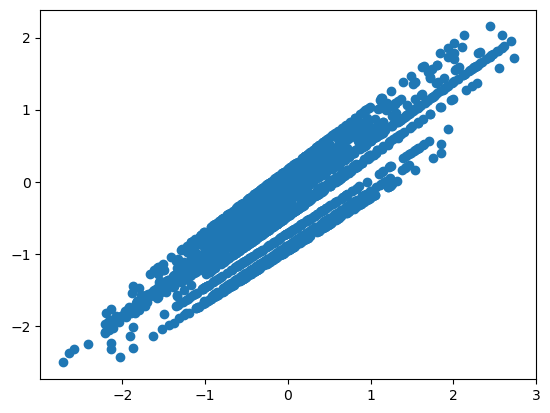

In [46]:
plt.scatter(nino_rel, nino_detrended)

In [22]:
# correlation between detrended & relative Nino indices in each month
min([xr.corr(nino_rel.groupby("time.month")[m+1], 
               nino_detrended.groupby("time.month")[m+1]).values for m in range(12)])

array(0.9999999)

In [21]:
# correlation between detrended & relative Nino indices in each 3-month period
min([xr.corr(nino_rel.rolling(time = 3, center = False).mean().groupby("time.month")[m+1],
        nino_detrended.rolling(time = 3, center = False).mean().groupby("time.month")[m+1]).values for m in range(12)])

array(0.99983695)

---
## **Check study region**

### **Elevation**

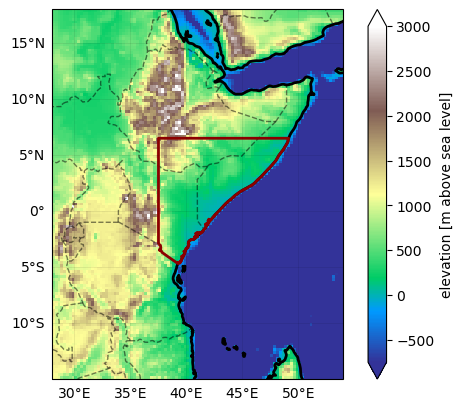

In [140]:
sf = gpd.read_file("sf_gha")
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(28,54), lat = slice(-15,18))

elev.plot(cmap = "terrain", vmin = -750, vmax = 3000, subplot_kws = proj_kw)

ax = plt.gcf().axes[0]
ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1)

plt.savefig("fig/elevation.png")


### **Investigate regional variations in seasonal cycle**

In [108]:
# seasonal cycle at each latitude - use daily data for this

chirps_d = xr.open_dataset("data/chirps25_daily.nc").precip.assign_attrs(long_name = "Mean precip")

chirps_sc_by_lat = chirps_d.groupby_bins(group = "latitude", bins = range(-5,15)).mean().mean("longitude").groupby("time.dayofyear").mean()
chirps_sc_by_lon = chirps_d.groupby_bins(group = "longitude", bins = range(33,52)).mean().mean("latitude").groupby("time.dayofyear").mean()

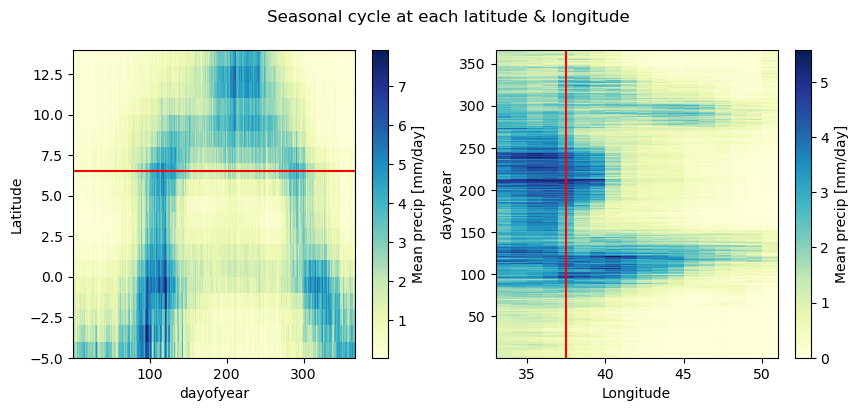

In [110]:
fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100)

chirps_sc_by_lat.transpose().plot(ax = axs[0], cmap = "YlGnBu") 
axs[0].set_ylabel("Latitude")
axs[0].axhline(6.5, color = "red")

chirps_sc_by_lon.plot(ax = axs[1], cmap = "YlGnBu") 
axs[1].set_xlabel("Longitude")
axs[1].axvline(37.5, color = "red")

plt.suptitle("Seasonal cycle at each latitude & longitude")
plt.savefig("fig/chirps_seasonal-cycle_latlon.png")

In [8]:
# and check each 2x2 grid cell
chirps_sc_ll = chirps_d.groupby_bins(group = "latitude", bins = range(-5,15,2)).mean().groupby_bins(group = "longitude", bins = range(33,52,2)).mean().groupby("time.dayofyear").mean()
chirps_sc_ll = chirps_sc_ll.sortby("latitude_bins", ascending = False)

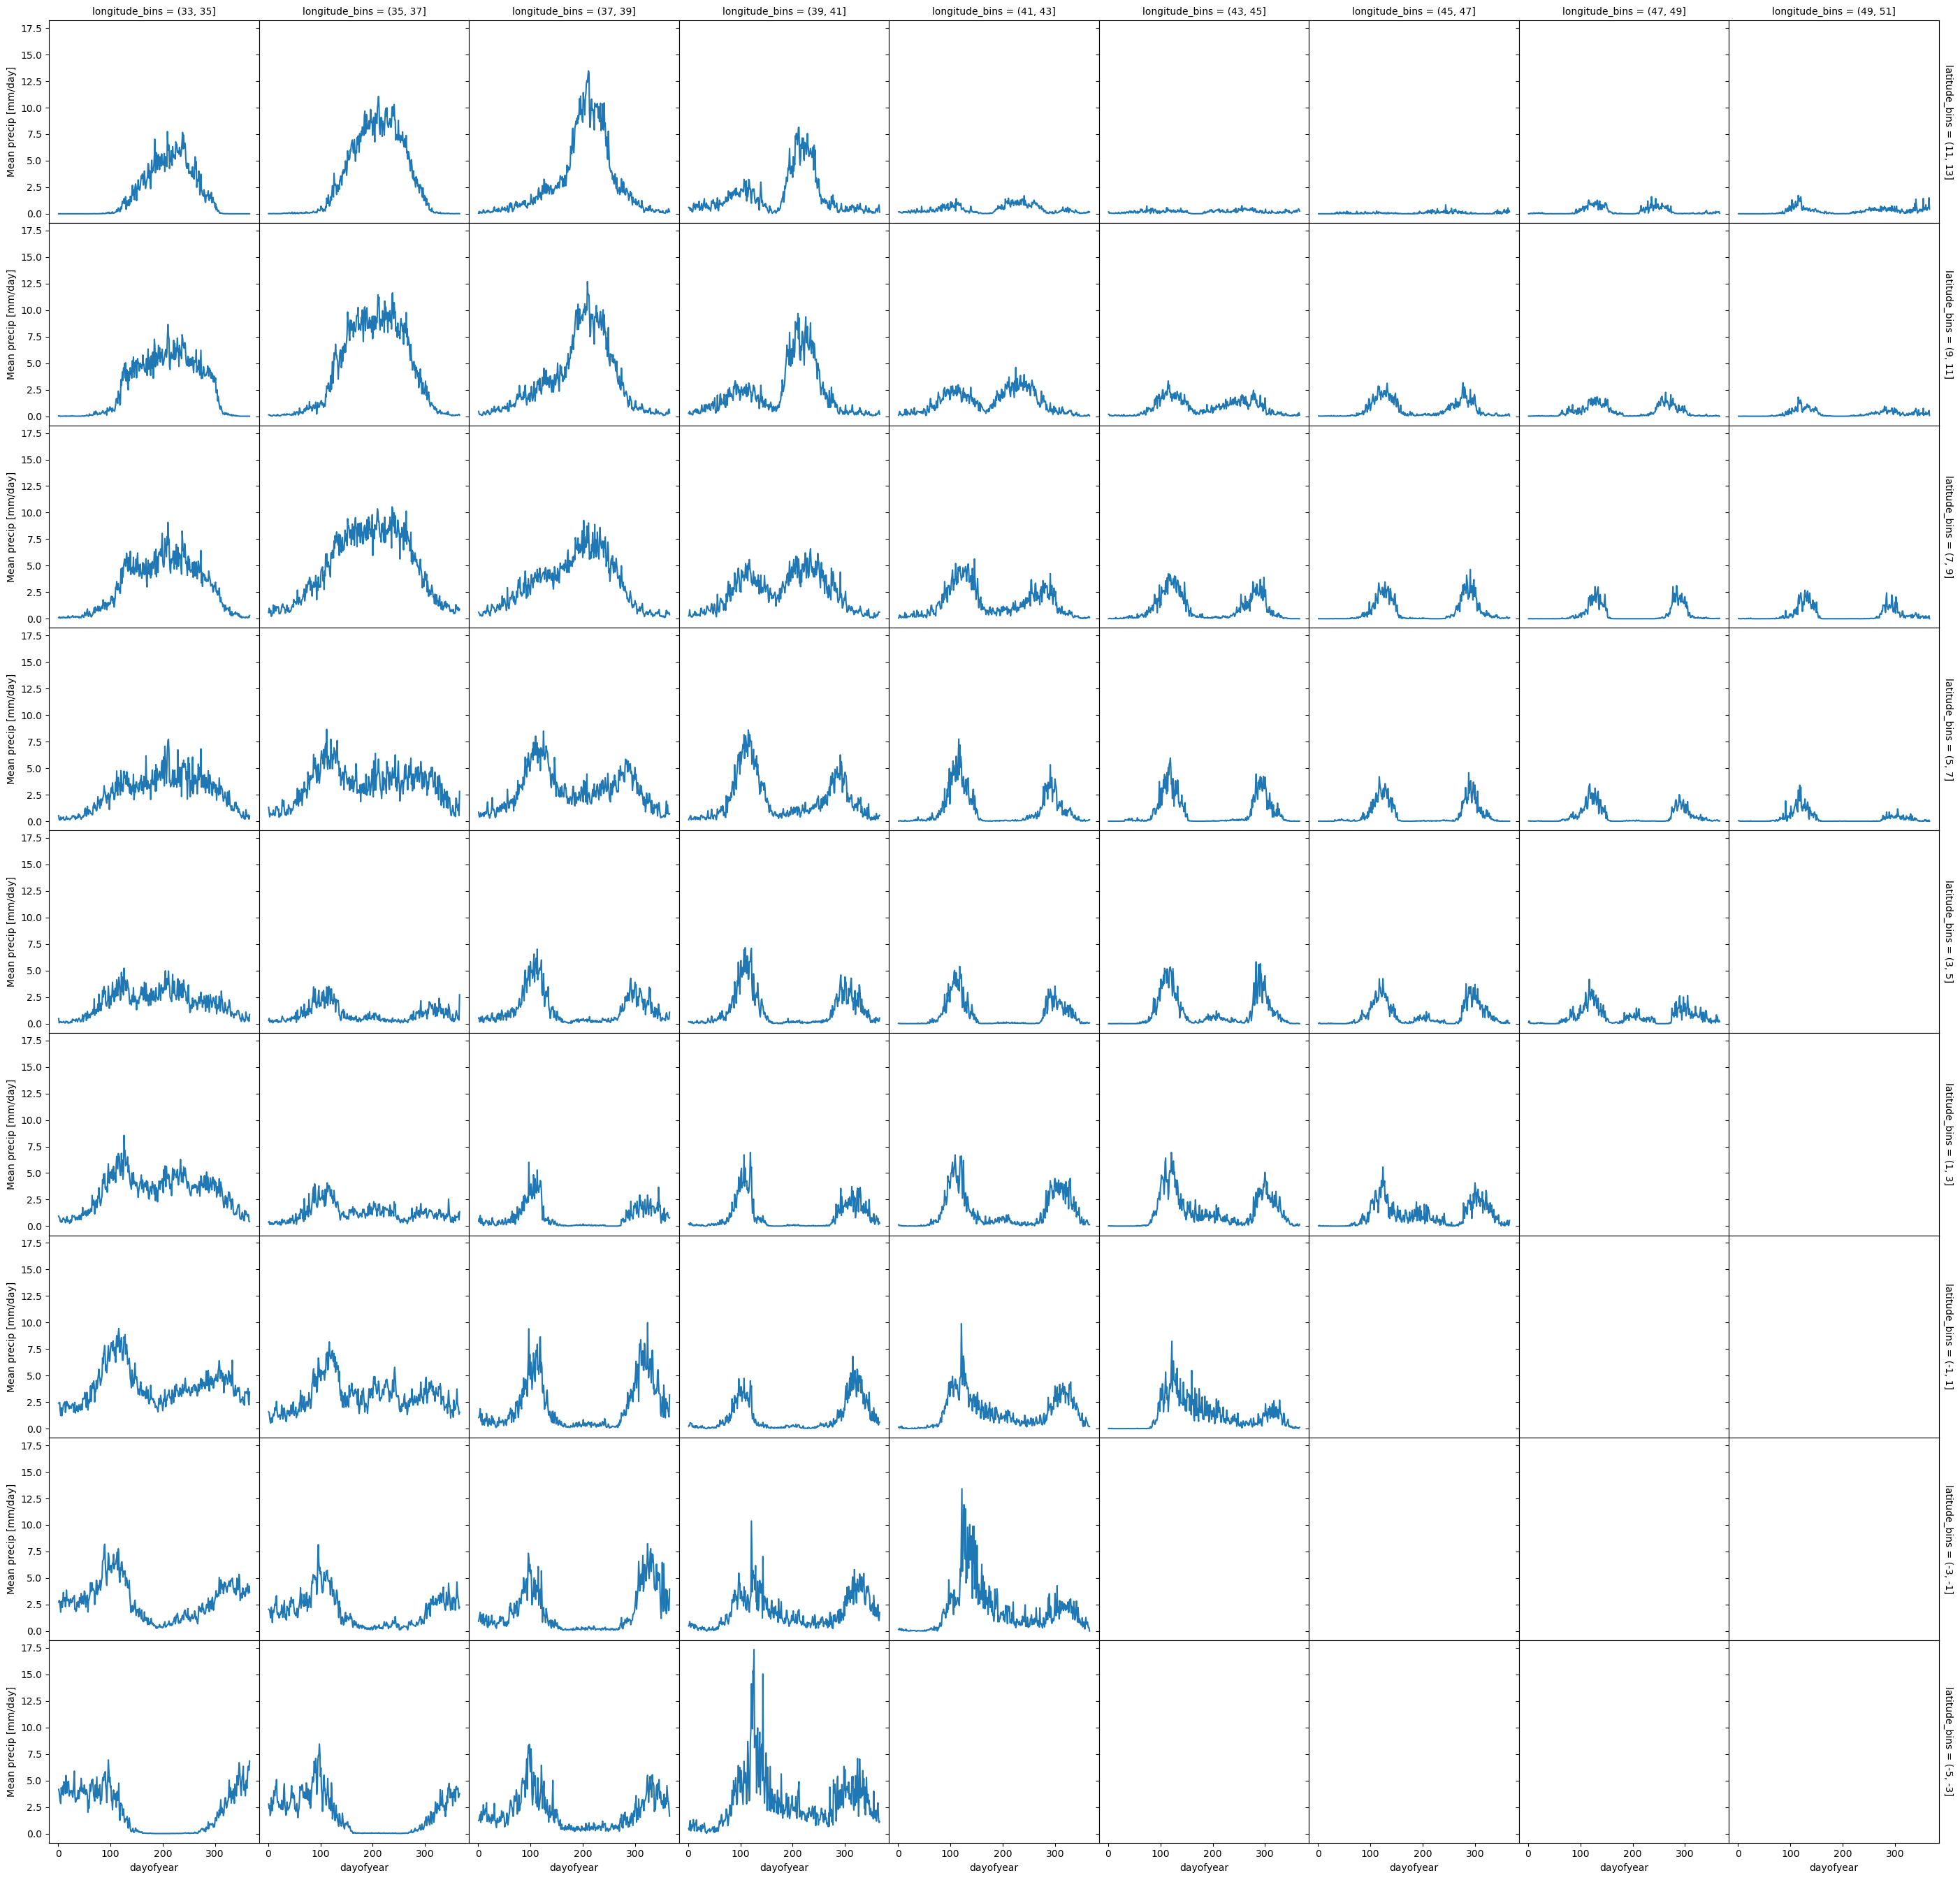

In [9]:
chirps_sc_ll.plot(col = "longitude_bins", row = "latitude_bins")
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.savefig("fig/chirps_seasonal-cycle_grid.png")

### **Candidate region**
_Test homogeneity of region by checking correlation with Kenya mean precipitation_

In [93]:
# create shapefile
sf = gpd.read_file("sf_gha").set_crs(cartopy.crs.PlateCarree()).clip((37.5, -5, 52, 6.5))
sf.to_file("sf_gha")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [94]:
chirps_m = xr.open_dataset("data/chirps25_daily.nc").precip.assign_attrs(long_name = "Mean precip").resample(time = "MS").mean()

kenya = gpd.read_file("sf/gha").to_crs(cartopy.crs.PlateCarree()).loc[[4]]
kenya_rm = regionmask.mask_3D_geopandas(kenya, chirps_m.longitude, chirps_m.latitude).squeeze(drop = True)
kenya_ts = chirps_m.where(kenya_rm == 1).mean(["latitude", "longitude"])

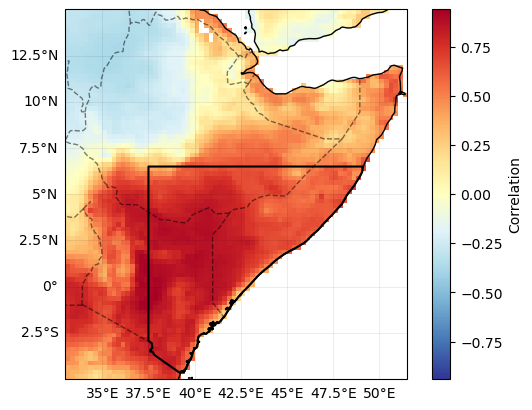

In [95]:
xr.corr(kenya_ts, chirps_m, ["time"]).assign_attrs(long_name = "Correlation", units = "").plot(subplot_kws = proj_kw, cmap = "RdYlBu_r")
ax = plt.gcf().axes[0]
sf.boundary.plot(ax = ax, color = "k")
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)    
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1)

plt.savefig("fig/candidate-region.png")

### **Koppen-Geiger classifications**

_koeppen-geiger.vu-wien.ac.at_

This version downloaded from GloH2O

In [51]:
# convert tiff to netcdf for easier plotting
from PIL import Image

kg = np.flip(np.array(Image.open('../../Data/koppen-geiger/Beck_KG_V1_present_0p083.tif')),0)
kg_arr = xr.DataArray(kg, name = "kg_cat", dims = ["lat", "lon"], coords = {"lat" : ("lat", np.linspace(-90,90, num = kg.shape[0])), "lon" : ("lon", np.linspace(-180,180, num = kg.shape[1]))})
kg_arr.to_netcdf("../../Data/koppen-geiger/kg_classifications.nc")

df = pd.read_fwf("../../Data/koppen-geiger/Beck_KG_legend.txt", widths = [8,5,38], skiprows = 3, nrows = 29, names = ["cat", "code", "desc"])
df["cat"] = [re.sub(":", "",n) for n in df.cat]
df = df.set_index("cat")
df.to_csv("../../Data/koppen-geiger/kg_legend.csv")

In [54]:
kg_arr = kg_arr.sel(lon = slice(33,52), lat = slice(-5,15))
sf = gpd.read_file("sf_gha")

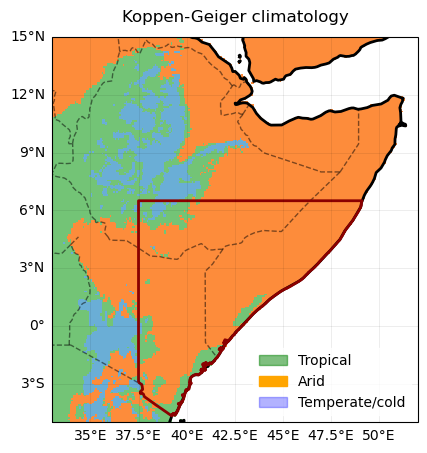

In [139]:
fig, ax = plt.subplots(dpi = 100, subplot_kw = proj_kw, figsize = (6,5))
[kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[str(r), "desc"], cmap = "Greens", add_colorbar = False) for r in range(1,4)]
[kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[str(r), "desc"], cmap = "Oranges", add_colorbar = False) for r in range(4,8)]
[kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[str(r), "desc"], cmap = "Blues", add_colorbar = False) for r in range(8,30)]

sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)    
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1)

plt.legend(handles = [matplotlib.patches.Patch(color = "green", label = "Tropical", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "orange", label = "Arid", alpha = 1),
                      matplotlib.patches.Patch(color = "blue", label = "Temperate/cold", alpha = 0.3)], 
           edgecolor = "w", loc = "lower right")

plt.title("Koppen-Geiger climatology")
plt.savefig("fig/koppen-geiger-climatology.png")

### **Correlation with Nino index**

In [18]:
nino34 = decode_times(xr.open_dataset("../90_data/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].resample(time = "MS").mean().sel(time = chirps.time)
sf = gpd.read_file("sf_gha")

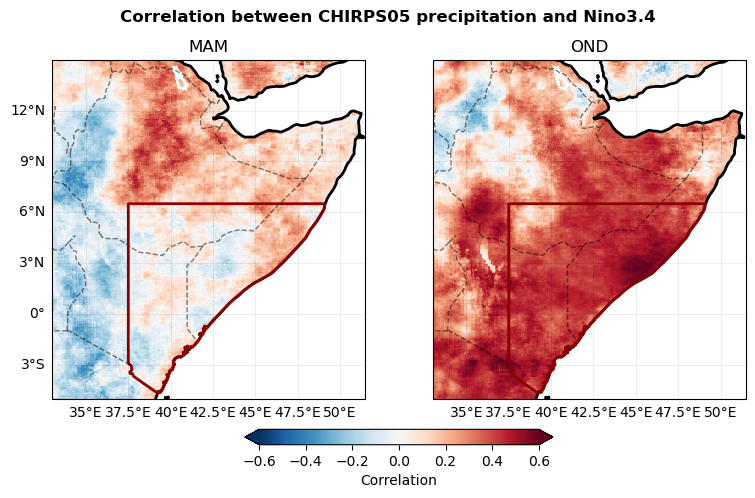

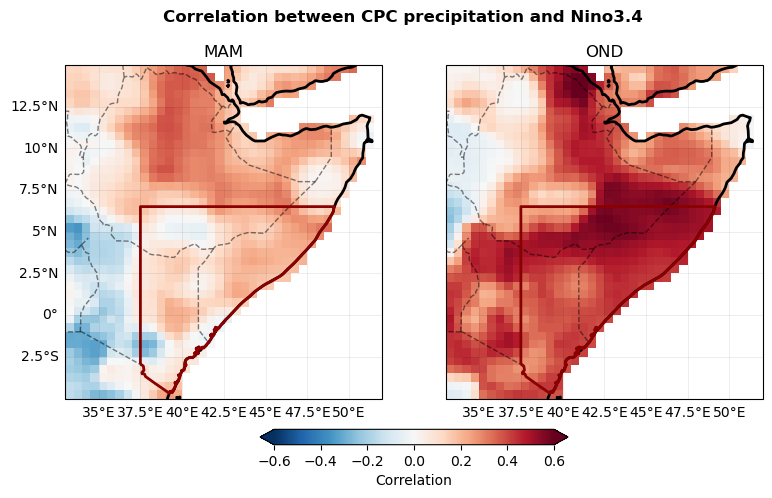

In [56]:
for dataset in ["chirps05", "cpc", "mswep"][:2]:
    
    pr = xr.open_dataset("data/"+dataset+"_monthly.nc").precip
    
    corr = [xr.corr(nino34.rolling(time = 3, center = False).mean().groupby("time.month")[m],
                    pr.rolling(time = 3, center = False).mean().groupby("time.month")[m], ["time"]) for m in [5,12]]
    
    fig, axs = plt.subplots(ncols = 2, figsize = (9,5), dpi = 100, subplot_kw = proj_kw)
    
    for i in range(2):
        ax = axs[i]
        cbar = corr[i].plot(ax = ax, vmin = -0.6, vmax = 0.6, cmap = "RdBu_r", add_colorbar = False)
        ax.set_title(["MAM", "OND"][i])
        
        sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
        ax.coastlines(lw = 2)
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
        ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1)
        
    axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0)
    plt.colorbar(cbar, ax = axs, location = "bottom", label = "Correlation", shrink = 0.9, fraction = 0.04, pad = 0.08, extend = "both")
    plt.suptitle("Correlation between "+dataset.upper()+" precipitation and Nino3.4", fontweight = "bold")
    
    plt.savefig("fig/"+dataset+"_nino3.4-correlation.png")

#### **Nino indices for climate explorer**

In [19]:
nino34 = decode_times(xr.open_dataset("../90_data/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].resample(time = "MS").mean()

# time series for each period to use as covariate
nino34_mam = nino34.rolling(time = 3, center = False).mean().groupby("time.month")[5].dropna("time", "any")
nino34_mam.assign_coords(time = nino34_mam.time.dt.year).to_dataframe().to_csv("data/nino3.4rel_mam.csv")

nino34_ond = nino34.rolling(time = 3, center = False).mean().groupby("time.month")[12].dropna("time", "any")
nino34_ond.assign_coords(time = nino34_ond.time.dt.year).to_dataframe().to_csv("data/nino3.4rel_ond.csv")

---
## **SPI, PET & SPEI**

### **SPI - CHIRPS, CPC & MSWEP**

In [59]:
nmonths = 3

for ds in ["chirps05", "cpc", "mswep"]:
    
    pr = xr.open_dataset("data/"+ds+"_monthly.nc").precip.rolling(time = nmonths, center = False).sum(keep_attrs = False)
    pr = pr.where(pr > 0).where(pr.sum("time") > 0).dropna("time", "all")
    
    pr_cal = pr.sel(time = slice("1980", "2010")).copy()
    
    spi = xr.concat([xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)),
                         pr.groupby("time.month")[m], 
                         fit(pr_cal.groupby("time.month")[m].dropna("time", "all"), dist = "gamma", method = "PWM"), 
                         input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr.groupby("time.month")[m].time) for m in [5,12]],
                "time").sortby("time").rename("spi")
    
    spi.to_netcdf("data/"+ds+"_spi"+str(nmonths).rjust(2, "0")+".nc")

### **PET & SPEI - CPC**

#### **PET** 
_Use Thornthwaite PET calculation with daily tmin/tmax data - suggested for arid/semi-arid regions such as this_

In [141]:
tmin, tmax = [xr.open_dataset("data/cpc_"+varnm+".nc")[varnm] for varnm in ["tmin", "tmax"]]
pet = convert_units_to(potential_evapotranspiration(tmin, tmax, method = "thornthwaite48"), "mm/day").resample(time = "MS").sum().assign_attrs(long_name = "Monthly PET").rename("pet")
pet.to_netcdf("data/cpc_pet.nc")

In [142]:
eff_pr = xr.open_dataset("data/cpc_monthly.nc").precip - xr.open_dataset("data/cpc_pet.nc").pet
sf = gpd.read_file("sf_gha")

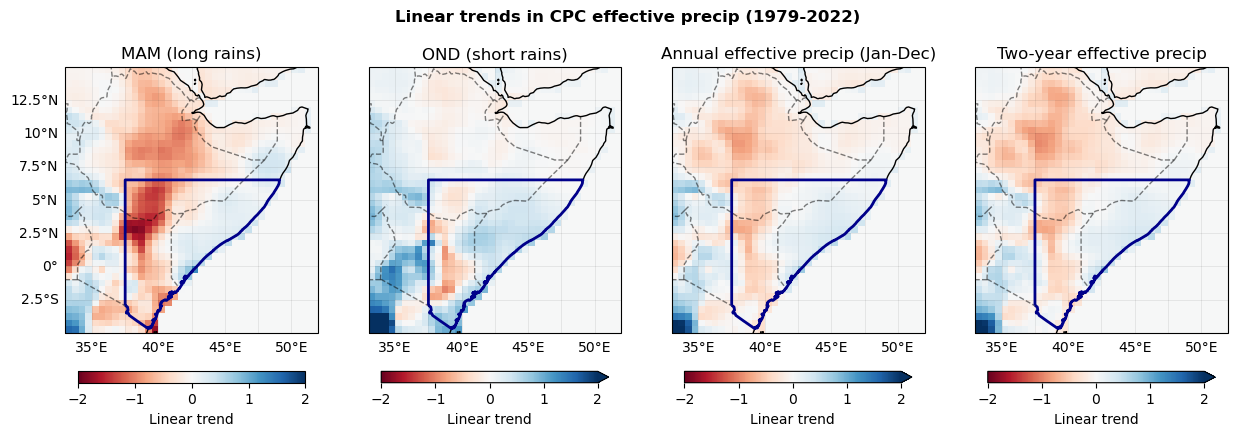

In [143]:
    # quick linear polynomial fit to check trends:
    fig, axs = plt.subplots(ncols = 4, figsize = (15,5), dpi = 100, subplot_kw = proj_kw)
    cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "pad" : 0.1}
    
    linear_trend(eff_pr.rolling(time = 3, center = False).mean().groupby("time.month")[5]).plot(ax = axs[0], cmap = "RdBu", cbar_kwargs = cbar_kwargs, vmin = -2, vmax = 2)
    axs[0].set_title("MAM (long rains)")
    
    linear_trend(eff_pr.rolling(time = 3, center = False).mean().groupby("time.month")[12]).plot(ax = axs[1], cmap = "RdBu", cbar_kwargs = cbar_kwargs, vmin = -2, vmax = 2)
    axs[1].set_title("OND (short rains)")
    
    linear_trend(eff_pr.rolling(time = 12, center = False).mean().groupby("time.month")[12]).plot(ax = axs[2], cmap = "RdBu", cbar_kwargs = cbar_kwargs, vmin = -2, vmax = 2)
    axs[2].set_title("Annual effective precip (Jan-Dec)")
    
    linear_trend(eff_pr.rolling(time = 24, center = False).mean().groupby("time.month")[12]).plot(ax = axs[3], cmap = "RdBu", cbar_kwargs = cbar_kwargs, vmin = -2, vmax = 2)
    axs[3].set_title("Two-year effective precip")
    
    for ax in axs:
        ax.coastlines()
        sf.boundary.plot(ax = ax, color = "darkblue", lw = 2)
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
        ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1)
    
    axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0)
    
    plt.suptitle("Linear trends in CPC effective precip ("+str(eff_pr.time.dt.year.values[0])+"-2022)", fontweight = "bold", y = 0.95)
    plt.savefig("fig/cpc_effpr_linear-trends.png")

#### **SPEI** 


In [2]:
pet = xr.open_dataset("data/cpc_pet.nc").pet
pr = xr.open_dataset("data/cpc_monthly.nc").precip
# tmin, tmax = [xr.open_dataset("data/cpc_"+varnm+".nc")[varnm].resample(time = "MS").mean() for varnm in ["tmin", "tmax"]]

In [41]:
nmonths = 3

spei_list = []
for season_end in [5, 12]:
    
    eff_pr_n = (pr - pet).rolling(time = nmonths, center = False).sum(keep_attrs = False).groupby("time.month")[season_end]
    eff_pr_n = eff_pr_n.where(eff_pr_n > 0, 0).where(eff_pr_n.sum("time") > 0).dropna("time", "all")
    
    epr_cal = eff_pr_n.sel(time = slice("1980", "2010")).copy()
    pars = xr.apply_ufunc(lambda x : np.asarray(list(glo.lmom_fit(x.copy()).values())), epr_cal,
                          input_core_dims = [["time"]], output_core_dims = [["dparams"]], vectorize = True).assign_coords(dparams = ["k", "loc", "scale"])
    
    spei = xr.apply_ufunc(lambda pr, dparams : norm.ppf(glo.cdf(pr, *dparams)), eff_pr_n, pars, 
                                input_core_dims=[["time"],["dparams"]], output_core_dims=[["time"]], vectorize = True).assign_coords(time = eff_pr_n.time)
    
    spei_list.append(spei)
    
spei = xr.concat(spei_list, "time").sortby("time").rename("spei")
spei.to_netcdf("data/cpc_spei"+str(nmonths).rjust(2, "0")+".nc")

### **PET - ERA5**

In [81]:
tas = xr.open_dataset("data/era5_t2m_Africa.nc").t2m.mean("expver")
pet = convert_units_to(potential_evapotranspiration(tas = tas, method = "thornthwaite48"), "mm/day").resample(time = "MS").sum().assign_attrs(long_name = "Monthly PET").rename("pet")
pet.to_netcdf("data/era5_pet.nc")

---
## **Drought classification maps**

### **GPCC**

In [82]:
gpcc = xr.concat([decode_times(xr.open_dataset(fnm, decode_times = False)) for fnm in sorted(glob.glob("../../Data/gpcc/*.nc"))], "time").sel(lon = slice(33,52), lat = slice(-5,15))
sf = gpd.read_file("sf_gha")

In [83]:
for n in [1,3,6,12,24,48]:
    
    fig, axs = plt.subplots(ncols = 3, figsize = (10,4), dpi = 100, subplot_kw = proj_kw)
    
    for i in range(3):
        
        ax = axs[i]
        
        cbar = drought_map(gpcc["di_"+str(n).rjust(2, "0")].isel(time = i), ax = ax)
                
        ax.coastlines()
        sf.boundary.plot(ax = ax, color = "darkblue", lw = 2)    
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
        ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1)
        
    axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0)
            
    drought_colorbar(cbar, axs, fraction = 0.05, label = str(n)+"-month drought classification")
    
    plt.suptitle("GPCC "+str(n)+"-month drought index", fontweight = "bold")
    
    plt.savefig("fig/spi_gpcc-di"+str(n).rjust(2, "0")+".png"); plt.close()

### **CHIRPS**

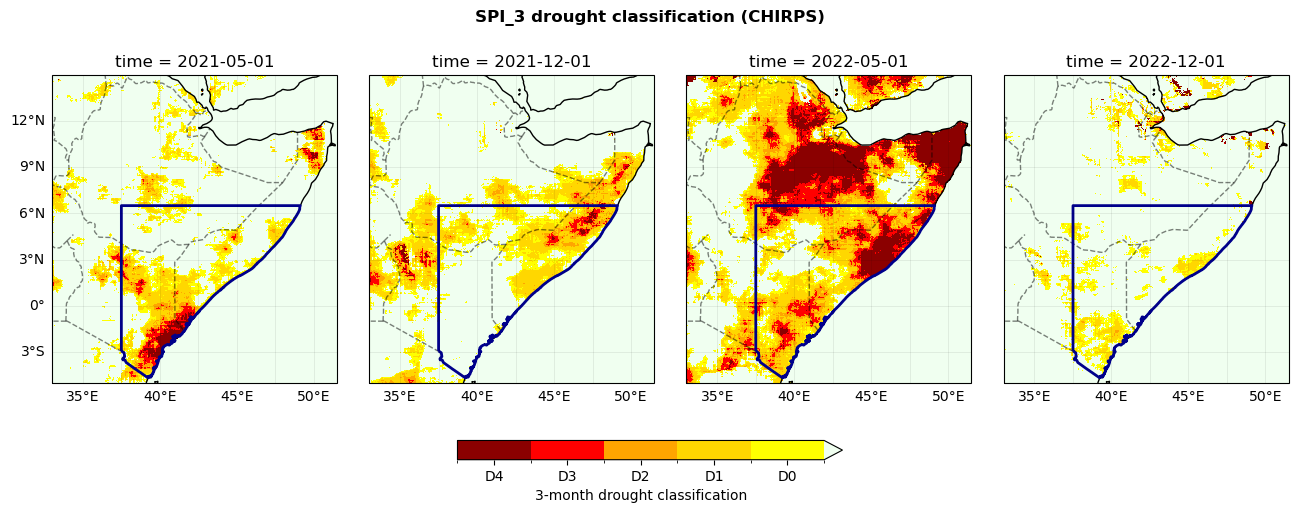

In [141]:
spi = xr.open_dataset("data/chirps05_spi03.nc").spi
sf = gpd.read_file("sf_gha")

fig, axs = plt.subplots(ncols = 4, figsize = (16,5), dpi = 100, subplot_kw = proj_kw)
plt.subplots_adjust(wspace = 0.1)

for i in range(4):
    ax = axs[i]
    t = ["2021-05", "2021-12", "2022-05", "2022-12"][i]
    
    cbar = drought_map(spi.sel(time = t), ax = ax)
    
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkblue", lw = 2)    
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1)
    
drought_colorbar(cbar, axs, fraction = 0.05, label = "3-month drought classification")
axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0)
plt.suptitle("SPI_3 drought classification (CHIRPS)", fontweight = "bold", y = 1.01)

plt.savefig("fig/chirps_spi3-drought-classification.png")

### **CPC**

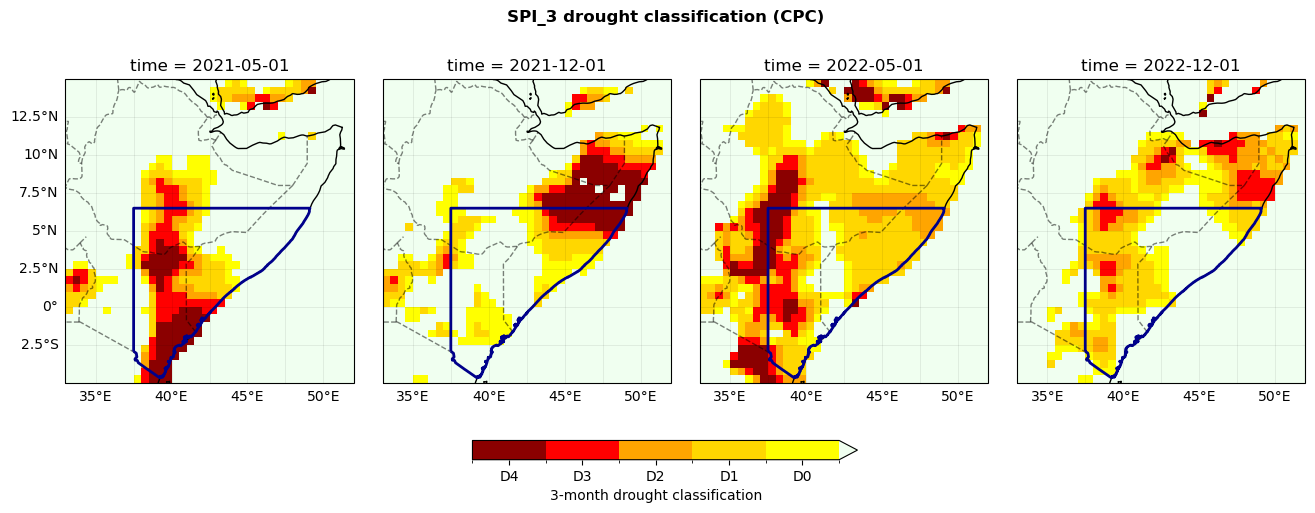

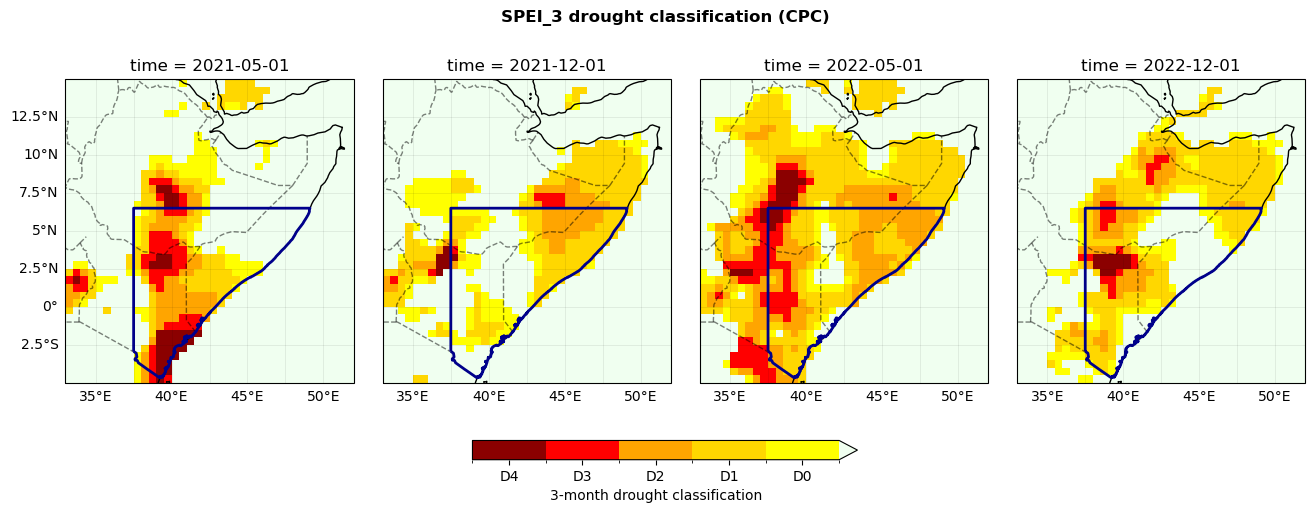

In [143]:
# 3-month SPI/SPEI maps

for varnm in ["spi", "spei"]:
    spei = xr.open_dataset("data/cpc_"+varnm+"03.nc")[varnm]
    sf = gpd.read_file("sf_gha")
    
    fig, axs = plt.subplots(ncols = 4, figsize = (16,5), dpi = 100, subplot_kw = proj_kw)
    plt.subplots_adjust(wspace = 0.1)
    
    for i in range(4):
        ax = axs[i]
        t = ["2021-05", "2021-12", "2022-05", "2022-12"][i]
        
        cbar = drought_map(spei.sel(time = t), ax = ax)
        
        ax.coastlines()
        sf.boundary.plot(ax = ax, color = "darkblue", lw = 2)    
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
        ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1)
        
    drought_colorbar(cbar, axs, fraction = 0.05, label = "3-month drought classification")
    axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0)
    plt.suptitle(varnm.upper()+"_3 drought classification (CPC)", fontweight = "bold", y = 1.01)
    
    plt.savefig("fig/cpc_"+varnm+"3-drought-classification.png")

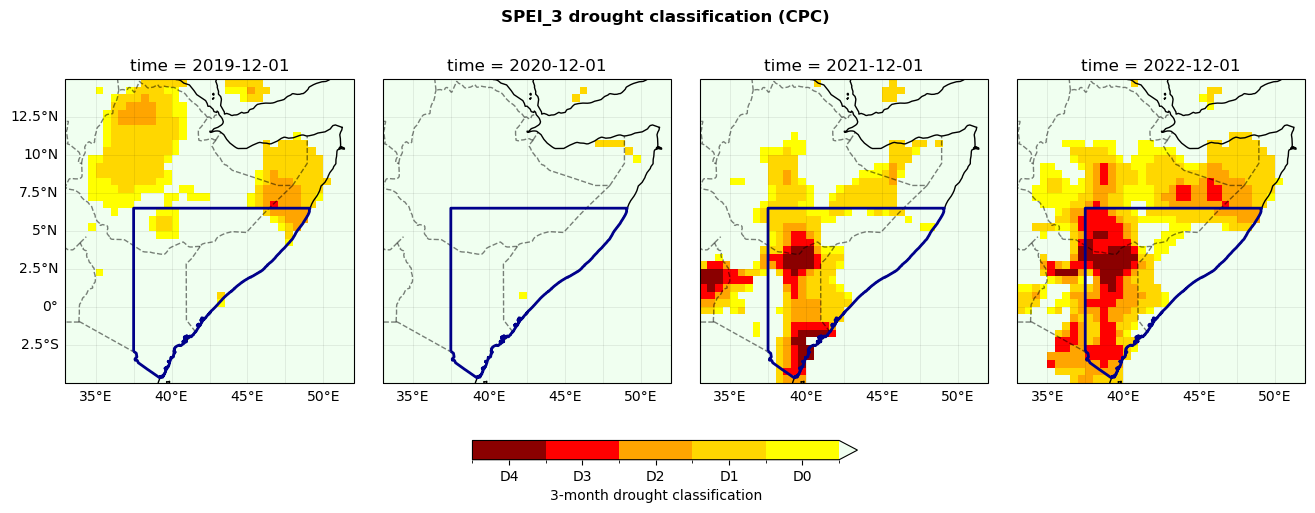

In [52]:
# 12-month SPEI

spei = xr.open_dataset("data/cpc_spei12.nc").spei
sf = gpd.read_file("sf_gha")
fig, axs = plt.subplots(ncols = 4, figsize = (16,5), dpi = 100, subplot_kw = proj_kw)
plt.subplots_adjust(wspace = 0.1)

for i in range(4):
    ax = axs[i]
    t = ["2019", "2020", "2021", "2022"][i]
    
    cbar = drought_map(spei.sel(time = t), ax = ax)
    
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkblue", lw = 2)    
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1)
    
drought_colorbar(cbar, axs, fraction = 0.05, label = "3-month drought classification")

axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0)

plt.suptitle("SPEI_3 drought classification (CPC)", fontweight = "bold", y = 1.01)

plt.savefig("fig/cpc_spei12-drought-classification.png")

---
## **Maps of fitted trends**

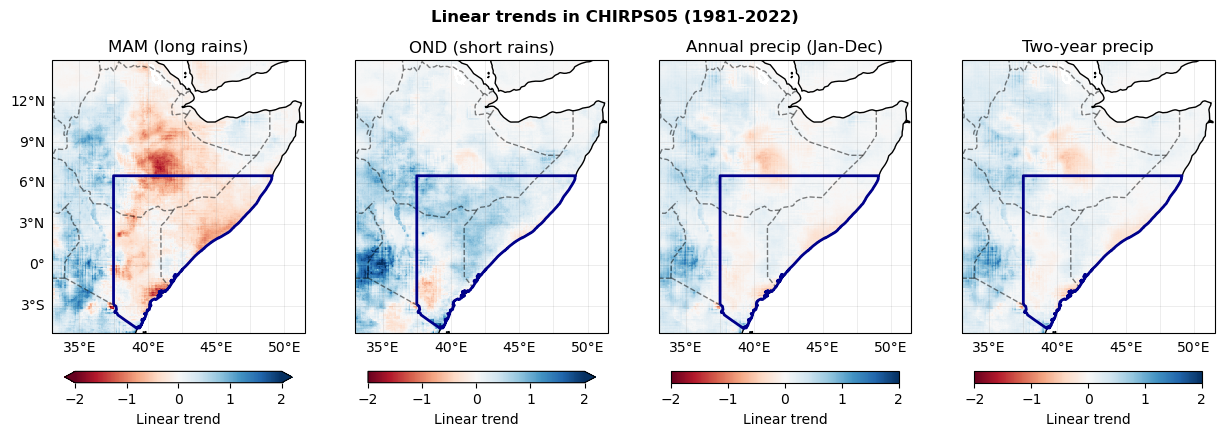

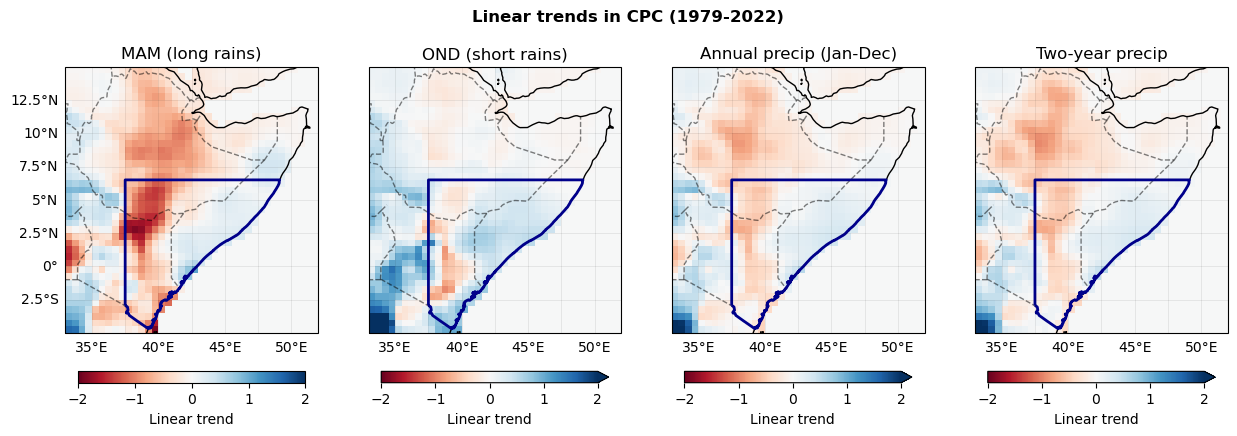

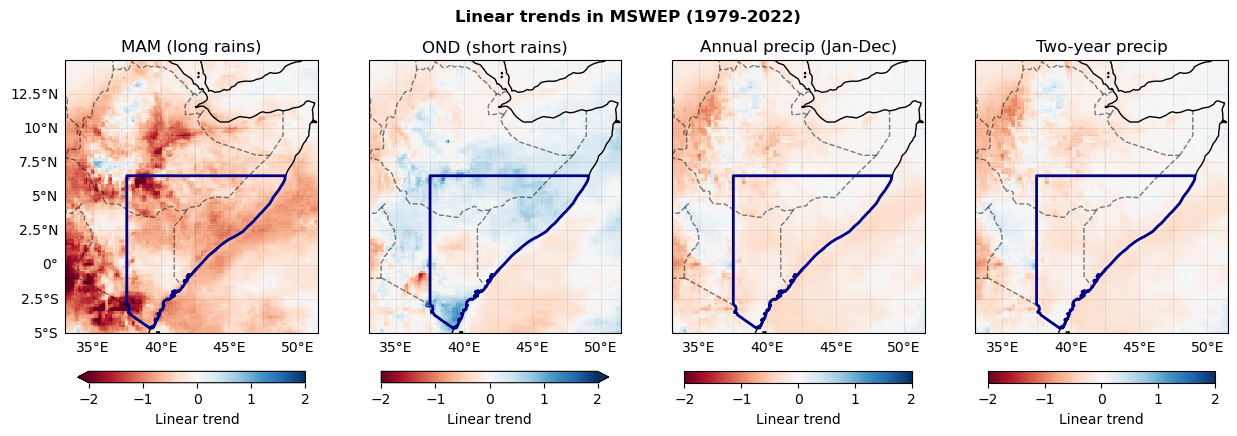

In [148]:
for dataset in ["chirps05", "cpc", "mswep"]:
    
    pr = xr.open_dataset("data/"+dataset+"_monthly.nc").precip
    
    # quick linear polynomial fit to check trends:
    fig, axs = plt.subplots(ncols = 4, figsize = (15,5), dpi = 100, subplot_kw = proj_kw)
    cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "pad" : 0.1}
    
    linear_trend(pr.rolling(time = 3, center = False).mean().groupby("time.month")[5]).plot(ax = axs[0], cmap = "RdBu", cbar_kwargs = cbar_kwargs, vmin = -2, vmax = 2)
    axs[0].set_title("MAM (long rains)")
    
    linear_trend(pr.rolling(time = 3, center = False).mean().groupby("time.month")[12]).plot(ax = axs[1], cmap = "RdBu", cbar_kwargs = cbar_kwargs, vmin = -2, vmax = 2)
    axs[1].set_title("OND (short rains)")
    
    linear_trend(pr.rolling(time = 12, center = False).mean().groupby("time.month")[12]).plot(ax = axs[2], cmap = "RdBu", cbar_kwargs = cbar_kwargs, vmin = -2, vmax = 2)
    axs[2].set_title("Annual precip (Jan-Dec)")
    
    linear_trend(pr.rolling(time = 24, center = False).mean().groupby("time.month")[12]).plot(ax = axs[3], cmap = "RdBu", cbar_kwargs = cbar_kwargs, vmin = -2, vmax = 2)
    axs[3].set_title("Two-year precip")
    
    for ax in axs:
        ax.coastlines()
        sf.boundary.plot(ax = ax, color = "darkblue", lw = 2)
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
        ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1)
    
    axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0)
    
    plt.suptitle("Linear trends in "+dataset.upper()+" ("+str(pr.time.dt.year.values[0])+"-2022)", fontweight = "bold", y = 0.95)
    plt.savefig("fig/"+dataset+"_linear-trends.png")

---
## **Time series for climate explorer**

### **CHIRPS**

#### **Long & short rains**

In [111]:
chirps_m = xr.open_dataset("data/chirps05_monthly.nc").precip
sf = gpd.read_file("sf_gha")
rm = regionmask.mask_3D_geopandas(sf, chirps_m.longitude, chirps_m.latitude).squeeze(drop = True)

# monthly time series of 3-month precip over the region
ea_m = chirps_m.where(rm == 1).mean(["latitude", "longitude"]).rolling(time = 3, center = False).sum()

In [112]:
for season in ["mam", "ond"]:
    
    csv_fnm = "ts/EA-drought_pr-"+season+"_chirps05.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CHIRPS 0.5deg "+season.upper()+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr_"+season+" [mm] "+season.upper()+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr_"+season
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    # get 3-month accumulated precip
    if season == "mam":
        pr = ea_m.groupby("time.month")[5]
    elif season == "ond":
        pr = ea_m.groupby("time.month")[12]
        
    pr.assign_coords(time = pr.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **24-month accumulated**

In [22]:
chirps = xr.open_dataset("data/chirps05_monthly.nc").precip
sf = gpd.read_file("sf_gha")
rm = regionmask.mask_3D_geopandas(sf, chirps.longitude, chirps.latitude).squeeze(drop = True)
chirps = chirps.where(rm == 1).mean(["latitude", "longitude"])


In [24]:
for m in ["12","24"]:
    
    csv_fnm = "ts/EA-drought_pr"+m+"_chirps05.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CHIRPS 0.5deg "+m+"m accumulated precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr"+m+" [mm/month] 2-year mean precipitation (Jan-Dec) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr"+m
    
    strx = "# CenTrends used prior to 1981: CHIRPS from 1981 onwards"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$strx " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    prx = chirps.rolling(time = int(m)).sum().groupby("time.month")[12].dropna("time", "any")
    prx.assign_coords(time = prx.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **CHIRPS + CenTrends**

#### **Long & short rains**

In [115]:
# CenTrends - also get monthly time series over the region
ct = xr.open_dataset("../../Data/CenTrends_v1_monthly.nc")
rm_ct = regionmask.mask_3D_geopandas(sf, ct.longitude, ct.latitude).squeeze(drop = True)

ct_m = ct.precip.where(rm_ct == 1).mean(["latitude", "longitude"]).rolling(time = 3, center = False).sum()

ct_mam = ct_m.groupby("time.month")[5]; ct_ond = ct_m.groupby("time.month")[12]
ea_mam = ea_m.groupby("time.month")[5]; ea_ond = ea_m.groupby("time.month")[12]

Text(0.5, 1.0, 'OND precip')

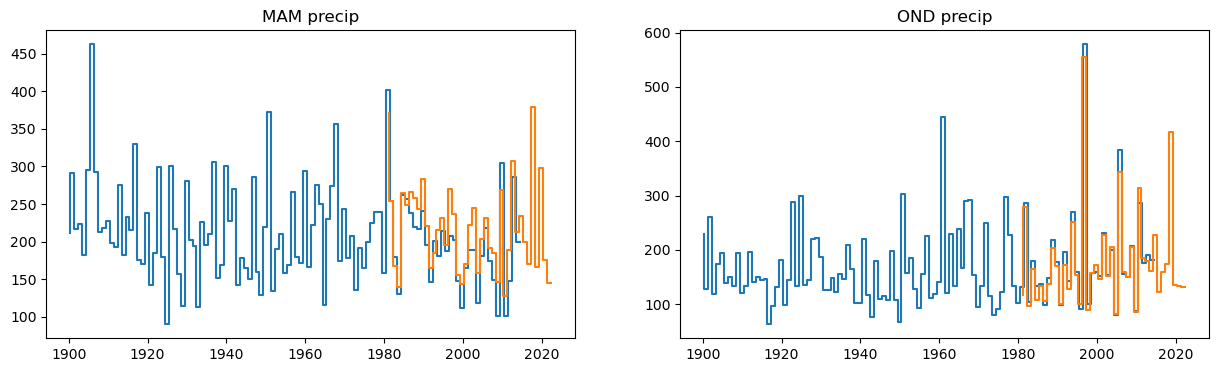

In [116]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,4), dpi = 100)

axs[0].step(ct_mam.time, ct_mam, label = "CenTrends")
axs[0].step(ea_mam.time, ea_mam, label = "CHIRPS")
axs[0].set_title("MAM precip")

axs[1].step(ct_mam.time, ct_ond, label = "CenTrends")
axs[1].step(ea_mam.time, ea_ond, label = "CHIRPS")
axs[1].set_title("OND precip")

In [117]:
pr_mam = xr.concat([ct_mam.sel(time = slice(None, ea_mam.time.min())), ea_mam], "time")
pr_ond = xr.concat([ct_ond.sel(time = slice(None, ea_ond.time.min())), ea_ond], "time")

In [118]:
for season in ["mam", "ond"]:
    
    csv_fnm = "ts/EA-drought_pr-"+season+"_chirps05+centrends01.dat"
    if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CHIRPS 0.5deg + CenTrends 0.1deg "+season.upper()+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr_"+season+" [mm] "+season.upper()+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr_"+season
    
    strx = "# CenTrends used prior to 1981: CHIRPS from 1981 onwards"

    ! echo "$str1 " > $csv_fnm
    ! echo "$strx " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pr = eval("pr_"+season)
    pr.assign_coords(time = pr.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

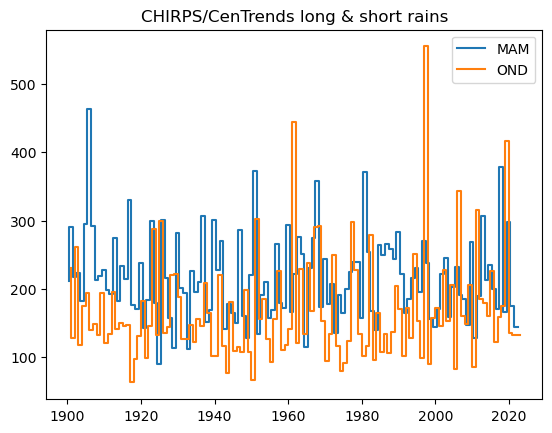

In [119]:
plt.step(pr_mam.time, pr_mam, label = "MAM")
plt.step(pr_ond.time, pr_ond, label = "OND")
plt.legend()
plt.title("CHIRPS/CenTrends long & short rains")
plt.savefig("fig/chirps_timeseries.png")

#### **24-month accumulated**

In [120]:
chirps = xr.open_dataset("data/chirps05_monthly.nc").precip
sf = gpd.read_file("sf_gha")
rm = regionmask.mask_3D_geopandas(sf, chirps.longitude, chirps.latitude).squeeze(drop = True)
chirps_m = chirps_m.where(rm == 1).mean(["latitude", "longitude"])

ct = xr.open_dataset("../../Data/CenTrends_v1_monthly.nc")
rm_ct = regionmask.mask_3D_geopandas(sf, ct.longitude, ct.latitude).squeeze(drop = True)

ct_m = ct.precip.where(rm_ct == 1).mean(["latitude", "longitude"])

# combined monthly time series
pr_m = xr.concat([ct_m.sel(time = slice(None, chirps_m.time.min())), chirps_m], "time")

In [121]:
for m in ["24"]:
    
    csv_fnm = "ts/EA-drought_pr"+m+"_chirps05+centrends01.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CHIRPS 0.5deg + CenTrends 0.1deg "+m+"m accumulated precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr"+m+" [mm/month] 2-year mean precipitation (Jan-Dec) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr"+m
    
    strx = "# CenTrends used prior to 1981: CHIRPS from 1981 onwards"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$strx " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    prx = pr_m.rolling(time = int(m)).mean().groupby("time.month")[12].dropna("time", "any")
    prx.assign_coords(time = prx.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **CPC**

#### **Precip**

In [80]:
cpc = xr.open_dataset("data/cpc_monthly.nc").precip

sf = gpd.read_file("sf_gha")
rm = regionmask.mask_3D_geopandas(sf, cpc.lon, cpc.lat).squeeze(drop = True)

cpc = cpc.where(rm == 1).mean(["lat", "lon"])
cpc_3m = cpc.rolling(time = 3, center = False).sum()

In [81]:
# long & short rains

for season in ["mam", "ond"]:
    
    csv_fnm = "ts/EA-drought_pr-"+season+"_cpc.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CPC "+season.upper()+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr_"+season+" [mm] "+season.upper()+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr_"+season
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    # get 3-month accumulated precip
    if season == "mam":
        pr = cpc_3m.groupby("time.month")[5]
    elif season == "ond":
        pr = cpc_3m.groupby("time.month")[12]
        
    pr.assign_coords(time = pr.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [121]:
# 2- & 3-year accumulation
for m in ["12", "24"]:
    
    csv_fnm = "ts/EA-drought_pr"+m+"_cpc.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CPC "+m+"m accumulated precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr"+m+" [mm] 2-year total precipitation (Jan-Dec) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr"+m
        
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    prx = cpc.rolling(time = int(m)).sum().groupby("time.month")[12].dropna("time", "any")
    prx.assign_coords(time = prx.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **Temperatures**

In [127]:
tas_3m = xr.open_dataset("data/cpc_tas.nc").tas.rolling(time = 3).mean()

sf = gpd.read_file("sf_gha")
rm = regionmask.mask_3D_geopandas(sf, tas_3m.lon, tas_3m.lat).squeeze(drop = True)

tas_3m = tas_3m.where(rm == 1).mean(["lat", "lon"])

In [128]:
for season in ["mam", "ond"]:
    
    csv_fnm = "ts/EA-drought_tas-"+season+"_cpc.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CPC "+season.upper()+" temperature - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# tas_"+season+" [degC] "+season.upper()+" mean daily temperature at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year tas_"+season
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    # get 3-month accumulated precip
    if season == "mam":
        tas = tas_3m.groupby("time.month")[5]
    elif season == "ond":
        tas = tas_3m.groupby("time.month")[12]
        
    tas.assign_coords(time = tas.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **PET**

In [129]:
pet_3m = xr.open_dataset("data/cpc_pet.nc").pet.rolling(time = 3).sum()

sf = gpd.read_file("sf_gha")
rm = regionmask.mask_3D_geopandas(sf, pet_3m.lon, pet_3m.lat).squeeze(drop = True)

pet_3m = pet_3m.where(rm == 1).mean(["lat", "lon"])

for season in ["mam", "ond"]:
    
    csv_fnm = "ts/EA-drought_pet-"+season+"_cpc.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CPC "+season.upper()+" PET - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pet_"+season+" [mm] "+season.upper()+" accumulated potential evapotranspiration (Thornthwaite) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pet_"+season
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    # get 3-month accumulated precip
    if season == "mam":
        pet = pet_3m.groupby("time.month")[5]
    elif season == "ond":
        pet = pet_3m.groupby("time.month")[12]
        
    pet.assign_coords(time = pet.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **MSWEP**

In [126]:
mswep = xr.open_dataset("data/mswep_monthly.nc").precip

sf = gpd.read_file("sf_gha")
rm = regionmask.mask_3D_geopandas(sf, mswep.lon, mswep.lat).squeeze(drop = True)

mswep = mswep.where(rm == 1).mean(["lat", "lon"])
pr_3m = mswep.rolling(time = 3, center = False).sum()

In [127]:
# long & short rains

for season in ["mam", "ond"]:
    
    csv_fnm = "ts/EA-drought_pr-"+season+"_mswep.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: MSWEP "+season.upper()+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr_"+season+" [mm] "+season.upper()+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr_"+season
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    # get 3-month accumulated precip
    if season == "mam":
        pr = pr_3m.groupby("time.month")[5]
    elif season == "ond":
        pr = pr_3m.groupby("time.month")[12]
        
    pr.assign_coords(time = pr.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [128]:
# 2- & 3-year accumulation
for m in ["24"]:
    
    csv_fnm = "ts/EA-drought_pr"+m+"_mswep.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: MSWEP "+m+"m accumulated precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr"+m+" [mm/month] 2-year mean precipitation (Jan-Dec) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr"+m
        
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    prx = mswep.rolling(time = int(m)).mean().groupby("time.month")[12].dropna("time", "any")
    prx.assign_coords(time = prx.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **ERA5**

#### **PET**

In [83]:
pet_3m = xr.open_dataset("data/era5_pet.nc").pet.rolling(time = 3).sum()

sf = gpd.read_file("sf_gha")
rm = regionmask.mask_3D_geopandas(sf, pet_3m.longitude, pet_3m.latitude).squeeze(drop = True)

pet_3m = pet_3m.where(rm == 1).mean(["latitude", "longitude"])

for season in ["mam", "ond"]:
    
    csv_fnm = "ts/EA-drought_pet-"+season+"_era5.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: ERA5 "+season.upper()+" PET - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pet_"+season+" [mm] "+season.upper()+" accumulated potential evapotranspiration (Thornthwaite) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pet_"+season
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    # get 3-month accumulated precip
    if season == "mam":
        pet = pet_3m.groupby("time.month")[5]
    elif season == "ond":
        pet = pet_3m.groupby("time.month")[12]
        
    pet.assign_coords(time = pet.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **Compare time series**

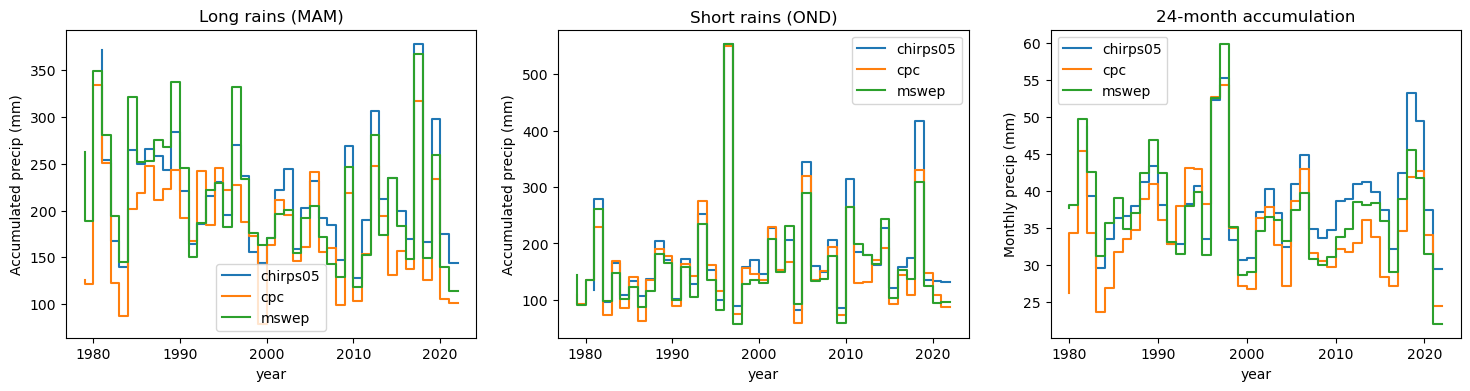

In [129]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,4), dpi = 100)

for ds in ["chirps05", "cpc", "mswep"]:
    
    pd.read_csv("ts/EA-drought_pr-mam_"+ds+".dat", comment = "#", sep = " ", names = ["year", ds], index_col = 0).plot(ax = axs[0], drawstyle = "steps")
    axs[0].set_title("Long rains (MAM)")
    axs[0].set_ylabel("Accumulated precip (mm)")
    
    pd.read_csv("ts/EA-drought_pr-ond_"+ds+".dat", comment = "#", sep = " ", names = ["year", ds], index_col = 0).plot(ax = axs[1], drawstyle = "steps")
    axs[1].set_title("Short rains (OND)")
    axs[1].set_ylabel("Accumulated precip (mm)")
 
    pd.read_csv("ts/EA-drought_pr24_"+ds+".dat", comment = "#", sep = " ", names = ["year", ds], index_col = 0).plot(ax = axs[2], drawstyle = "steps")
    axs[2].set_title("24-month accumulation")
    axs[2].set_ylabel("Monthly precip (mm)")

plt.savefig("fig/gridded-precip-timeseries.png")

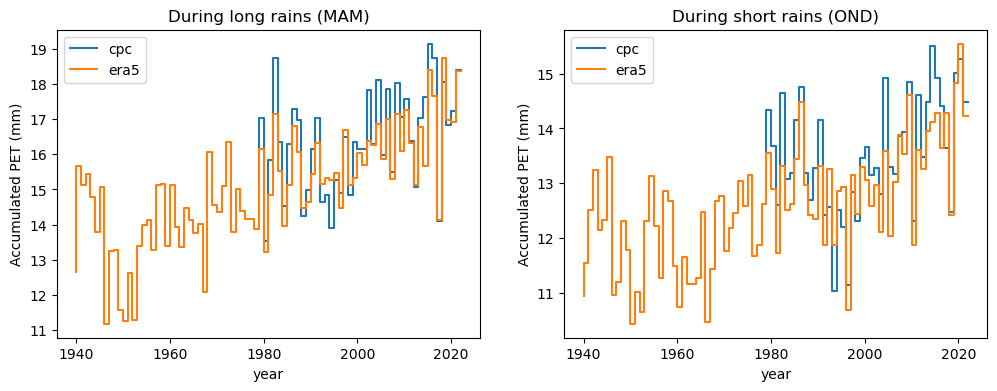

In [99]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

for ds in ["cpc", "era5"]:
    
    pd.read_csv("ts/EA-drought_pet-mam_"+ds+".dat", comment = "#", sep = " ", names = ["year", ds], index_col = 0).plot(ax = axs[0], drawstyle = "steps")
    axs[0].set_title("During long rains (MAM)")
    axs[0].set_ylabel("Accumulated PET (mm)")
    
    pd.read_csv("ts/EA-drought_pet-ond_"+ds+".dat", comment = "#", sep = " ", names = ["year", ds], index_col = 0).plot(ax = axs[1], drawstyle = "steps")
    axs[1].set_title("During short rains (OND)")
    axs[1].set_ylabel("Accumulated PET (mm)")

plt.savefig("fig/gridded-pet-timeseries.png")

---
## **Other exploratory plots**

---
### **Proportion of precip per season**

In [279]:
chirps = xr.open_dataset("data/chirps05_monthly.nc").precip
sf = gpd.read_file("sf_gha")
rm = regionmask.mask_3D_geopandas(sf, chirps.longitude, chirps.latitude).squeeze(drop = True)
chirps = chirps.where(rm == 1).mean(["latitude", "longitude"])

pr = xr.concat([chirps.sel(time = [m in [1,2] for m in chirps.time.dt.month]).resample(time = "AS-JAN").sum(),
                chirps.sel(time = [m in [3,4,5] for m in chirps.time.dt.month]).resample(time = "AS-MAR").sum(),
                chirps.sel(time = [m in [6,7,8,9] for m in chirps.time.dt.month]).resample(time = "AS-JUN").sum(),
                chirps.sel(time = [m in [10,11,12] for m in chirps.time.dt.month]).resample(time = "AS-OCT").sum()], "time").sortby("time").dropna("time", "any")

# wrangle into dataframe, arrange as one column per season
df = pr.to_dataframe()
df["year"] = df.index.year
df["season"] = [{1 : "JF", 3:"MAM", 6:"JJAS", 10:"OND"}[m] for m in df.index.month]
df = df.groupby(["year", "season"]).sum("season").unstack().dropna(axis = 0, how = "any").precip[["JF", "MAM", "JJAS", "OND"]]

In [388]:
df.to_csv("data/chirps05_pr_seasonal.csv")

In [380]:
nino_df = pd.merge(pd.read_csv("data/nino3.4rel_mam.csv", names = ["year", "nino_mam"], index_col = 0, skiprows = 1),
                   pd.merge(pd.read_csv("data/nino3.4rel_ond.csv", names = ["year", "nino_ond"], index_col = 0, skiprows = 1), df, left_index=True, right_index=True),
                   left_index=True, right_index=True)

In [289]:
df.std() / df.mean()

season
JF      0.664695
MAM     0.269136
JJAS    0.143588
OND     0.514254
dtype: float32

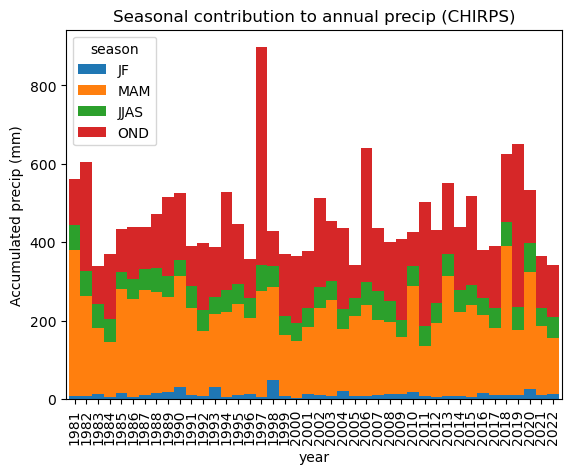

In [356]:
df.plot.bar(stacked = True, ylabel = "Accumulated precip (mm)", title = "Seasonal contribution to annual precip (CHIRPS)", width = 1)
plt.savefig("fig/seasonal-contribution-chirps.png")

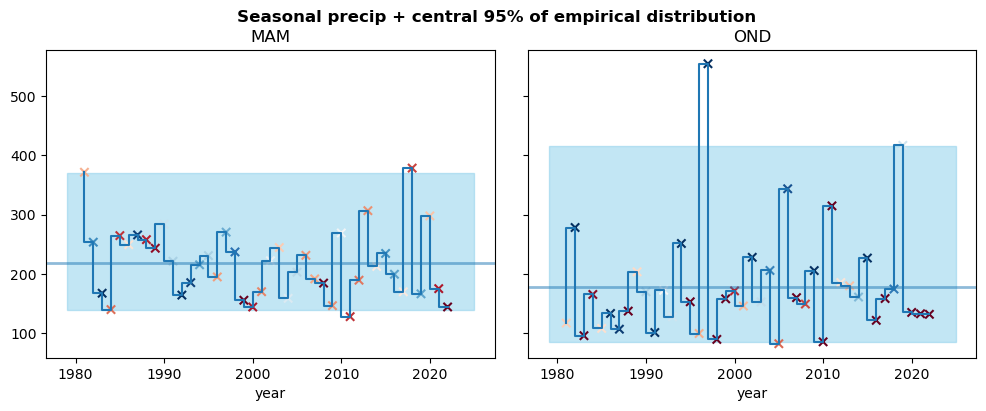

In [386]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, sharey = True)
plt.subplots_adjust(wspace = 0.075)
for i in range(2):
    seasn = ["MAM", "OND"][i]
    ax = axs[i]
    df[seasn].plot(drawstyle = "steps", ax = ax)
    ax.axhline(df[seasn].mean(), lw = 2, alpha = 0.5)
    
    # ax.add_patch(Rectangle((1979, df[seasn].mean() - 1.96*df[seasn].std()), width = 46, height = 2*1.96*df[seasn].std(), color = "skyblue", alpha = 0.5))
    ax.add_patch(Rectangle((1979, df[seasn].quantile(0.025)), width = 46, height = np.diff(df[seasn].quantile([0.025, 0.975])), color = "skyblue", alpha = 0.5))
    ax.set_title(seasn)

axs[0].scatter(nino_df.index, nino_df.MAM, c = nino_df.nino_mam, cmap = "RdBu", vmin = -1, vmax = 1, marker = "x")
axs[1].scatter(nino_df.index, nino_df.OND, c = nino_df.nino_ond, cmap = "RdBu", vmin = -1, vmax = 1, marker = "x")

plt.suptitle("Seasonal precip + central 95% of empirical distribution", fontweight = "bold")
plt.savefig("fig/seasonal-ts-chirps.png")

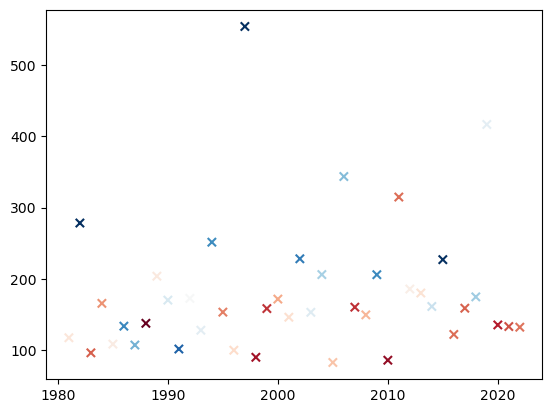

In [376]:
plt.scatter(nino_df.index, nino_df.OND, c = nino_df.nino_ond, cmap = "RdBu", vmin = -2, vmax = 2, marker = "x")

---
## **Univariate trend fitting**

### **Choose distribution**

#### **CHIRPS**

In [2]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *
from wwa_nonstationary_fitting import *

# load data, add column for constant (needed for statsmodels fitting)
df = pd.merge(reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'inner'),
                                     [pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year"),
                                      pd.read_csv("data/nino3.4rel_mam.csv", names = ["year", "nino_mam"], index_col = 0, skiprows = 1),
                                      pd.read_csv("data/nino3.4rel_ond.csv", names = ["year", "nino_ond"], index_col = 0, skiprows = 1),
                                      pd.read_csv("ts/EA-drought_pr-mam_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr_mam"], index_col = 0),
                                      pd.read_csv("ts/EA-drought_pr-ond_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr_ond"], index_col = 0),
                                      pd.read_csv("ts/EA-drought_pr12_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr12"], index_col = 0)]),
                              pd.read_csv("ts/EA-drought_pr24_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr24"], index_col = 0), left_index = True, right_index = True, how = "outer")
for varnm in ["pr_ond", "pr_mam", "pr12", "pr24"]: df["log_"+varnm] = np.log(df[varnm])

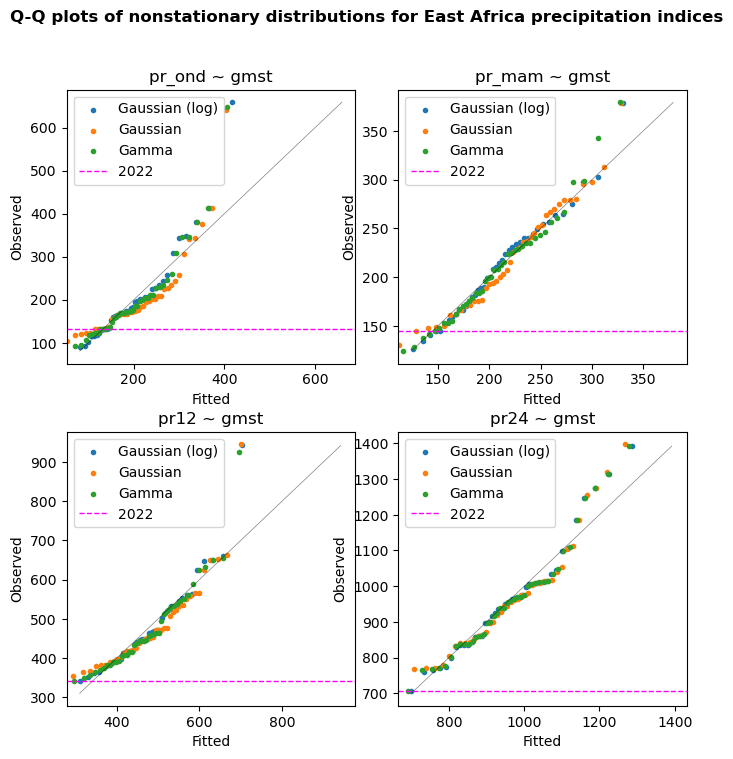

In [45]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (8,8), dpi = 100)
plt.subplots_adjust(wspace = 0.15, hspace = 0.25)

cov_name = "gmst"

for i in range(4):
    varnm = ["pr_ond", "pr_mam", "pr12", "pr24"][i]
    ax = plt.gcf().axes[i]
    
    if varnm == "pr_mam" and cov_name == "nino_ond": 
        cov = "nino_mam"
    else:
        cov = cov_name
        
    event_cov = df.loc[2022, cov]
    
        
    ns_qqplot(ns_fit(norm, "fixeddisp", df, cov, "log_"+varnm), event_cov, ax = ax, label = "Gaussian (log)", transform = np.exp)
    ns_qqplot(ns_fit(norm, "fixeddisp", df, cov, varnm), event_cov, ax = ax, label = "Gaussian", xyline = False)
    # ns_qqplot(ns_fit(lognorm, "fixeddisp", df, cov, varnm), event_cov, ax = ax, label = "lognormal", xyline = False)
    # ns_qqplot(ns_fit(gamma, "fixeddisp", df, cov, varnm), event_cov, ax = ax, label = "gamma", xyline = False)
    
    # compare to Gamma distribution fitted in R
    gamma_rfit = pd.read_csv("rfit-gamma_"+re.sub("pr_", "", varnm)+"_"+cov+".csv")
    ax.scatter(gamma_rfit.x, gamma_rfit.y, marker = ".", label = "Gamma")

    ax.axhline(df.loc[2022, varnm], color = "magenta", lw = 1, ls = "--", label = "2022")

    ax.legend()
    ax.set_title(varnm+" ~ "+cov)
    ax.set_xlim(ax.get_ylim())
        
plt.suptitle("Q-Q plots of nonstationary distributions for East Africa precipitation indices", fontweight = "bold")

# still slightly skewed, but lower tails generally well fitted
plt.savefig("fig/dist-check_qq_chirps_"+re.sub("_.+", "", cov_name)+".png")

In [92]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (15,7), dpi = 100)
plt.subplots_adjust(wspace = 0.15, hspace = 0.25)

for i in range(4):
    varnm = ["pr_ond", "pr_mam", "pr12", "pr24"][i]
    ax = plt.gcf().axes[i]
    
    # get x & y values for fitting & plotting
    y = df[varnm].dropna()
    x = np.linspace(max(y.min() - y.std() * 2, 0.1), y.max() + y.std() * 2, 100)
    
    logy = np.log(y)
    logx = np.linspace(logy.min() - logy.std() * 2, logy.max() + logy.std() * 2, 100)
    
    # scaling factor used to normalise plots
    k = (np.diff(np.linspace(logx.min(), logx.max(), 30)) / np.diff(np.linspace(x.min(), x.max(), 30))).mean()
    
    y_normfit = norm.pdf(x, *norm.fit(y))
    y_lnormfit = lognorm.pdf(x, *lognorm.fit(y, 0.5, loc = np.log(y).mean()))
    y_normfit_logpr = norm.pdf(logx, *norm.fit(logy))
    y_gammafit = gamma.pdf(x, *gamma.fit(y, 5, loc = y.min(), scale = y.std()*2))
            
    ax.hist(y, bins = np.arange(x.min(), x.max()+10, 30), alpha = 0.5, density = True)
    y.plot.kde(ax = ax, bw_method = 0.25, color = "tab:blue", label = "KDE")
    ax.plot(x, y_normfit, color = "darkred", label = "Gaussian", ls = "dotted")
    ax.plot(x, y_lnormfit, color = "k", label = "lognormal")
    ax.plot(np.exp(logx), y_normfit_logpr * k, color = "darkgreen", label = "Gaussian log(pr)")
    # ax.plot(x, y_gammafit, color = "darkred", label = "gamma")
    
    ax.axvline(y[2022], color = "magenta", ls = "--", label = "_Event")
    
    ax.set_xlim(x.min(), x.max())
    ax.set_title(varnm)
    ax.legend(loc = "upper right")
        
plt.suptitle("Check of stationary distributions for East Africa precipitation indices", fontweight = "bold")
plt.savefig("fig/distribution-check.png")

Text(0.5, 0.98, 'Exceedance probabilities depending on method used')

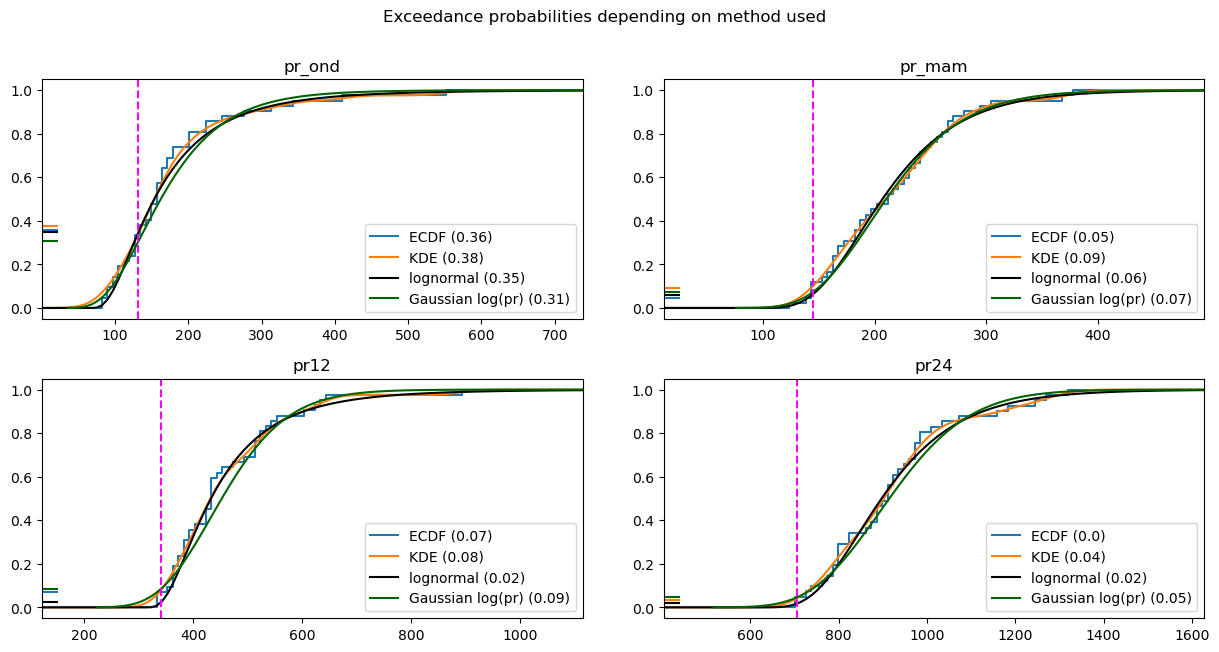

In [85]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (15,7), dpi = 100)
plt.subplots_adjust(wspace = 0.15, hspace = 0.25)
kde_bw = 0.25

for i in range(4):
    varnm = ["pr_ond", "pr_mam", "pr12", "pr24"][i]
    ax = plt.gcf().axes[i]
    
    # get x & y values for fitting & plotting
    y = df[varnm].dropna()
    x = np.linspace(max(y.min() - y.std() * 2, 0.1), y.max() + y.std() * 2, 100)
    logy = np.log(y)
    logx = np.linspace(logy.min() - logy.std() * 2, logy.max() + logy.std() * 2, 100)
    
    lnorm_fit = lognorm.fit(y, 0.5, loc = np.log(y).mean())
    norm_fit = norm.fit(logy)
        
    ep_kde = kde_ep(y, y[2022], bw_method = kde_bw)
    ep_ecdf = ecdf_ep(y, y[2022])
    ep_lognorm = lognorm.cdf(y[2022], *lnorm_fit)
    ep_norm_logpr = norm.cdf(logy[2022], *norm.fit(logy))
    
    ax.step(x, ecdf(y)(x), label = "ECDF ("+str(ep_ecdf.round(2))+")")
    ax.plot(x, (kde(y, bw_method = kde_bw)(x) / kde(y, bw_method = kde_bw)(x).sum()).cumsum(), label = "KDE ("+str(ep_kde.round(2))+")")
    ax.plot(x, lognorm.cdf(x, *lnorm_fit), color = "k", label = "lognormal ("+str(ep_lognorm.round(2))+")")
    ax.plot(np.exp(logx), norm.cdf(logx, *norm.fit(logy)), color = "darkgreen", label = "Gaussian log(pr) ("+str(ep_norm_logpr.round(2))+")")
    ax.axvline(y[2022], color = "magenta", ls = "dashed")
    
    
    ax.scatter(x[0], ep_kde, marker = "_", s = 500, color = "tab:orange")
    ax.scatter(x[0], ep_ecdf, marker = "_", s = 500, color = "tab:blue")
    ax.scatter(x[0], ep_lognorm, marker = "_", s = 500, color = "k")
    ax.scatter(x[0], ep_norm_logpr, marker = "_", s = 500, color = "darkgreen")
    
    ax.set_title(varnm)
    ax.legend(loc = "lower right")
    ax.set_xlim(x.min(), x.max())
    
plt.suptitle("Exceedance probabilities depending on method used")

#### **CPC**

In [4]:
# load data, add column for constant (needed for statsmodels fitting)
df = pd.merge(reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'inner'),
                                     [pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year"),
                                      pd.read_csv("data/nino3.4rel_mam.csv", names = ["year", "nino_mam"], index_col = 0, skiprows = 1),
                                      pd.read_csv("data/nino3.4rel_ond.csv", names = ["year", "nino_ond"], index_col = 0, skiprows = 1),
                                      pd.read_csv("ts/EA-drought_pr-mam_cpc.dat", comment = "#", sep = " ", names = ["year", "pr_mam"], index_col = 0),
                                      pd.read_csv("ts/EA-drought_pr-ond_cpc.dat", comment = "#", sep = " ", names = ["year", "pr_ond"], index_col = 0),
                                      pd.read_csv("ts/EA-drought_pr12_cpc.dat", comment = "#", sep = " ", names = ["year", "pr12"], index_col = 0)]),
                              pd.read_csv("ts/EA-drought_pr24_cpc.dat", comment = "#", sep = " ", names = ["year", "pr24"], index_col = 0), left_index = True, right_index = True, how = "outer")
for varnm in ["pr_ond", "pr_mam", "pr12", "pr24"]: df["log_"+varnm] = np.log10(df[varnm])

In [7]:
mdl = ns_fit(norm, "fixeddisp", df, "gmst", "log_pr_mam")

In [13]:
return_period(mdl, df.loc[2022, "log_pr_mam"], df.loc[2022, "gmst"]-1.2, lower = True)

116.49658522107255

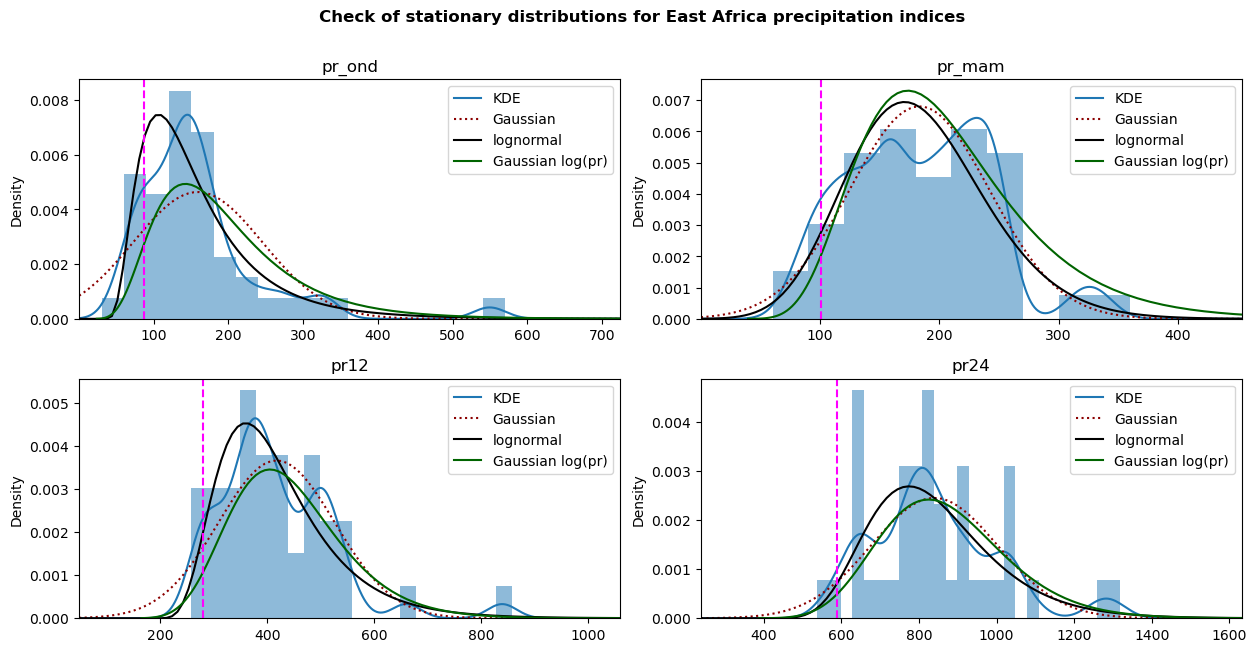

In [87]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (15,7), dpi = 100)
plt.subplots_adjust(wspace = 0.15, hspace = 0.25)

for i in range(4):
    varnm = ["pr_ond", "pr_mam", "pr12", "pr24"][i]
    ax = plt.gcf().axes[i]
    
    # get x & y values for fitting & plotting
    y = df[varnm].dropna()
    x = np.linspace(max(y.min() - y.std() * 2, 0.1), y.max() + y.std() * 2, 100)
    
    logy = np.log(y)
    logx = np.linspace(logy.min() - logy.std() * 2, logy.max() + logy.std() * 2, 100)
    
    # scaling factor used to normalise plots
    k = (np.diff(np.linspace(logx.min(), logx.max(), 30)) / np.diff(np.linspace(x.min(), x.max(), 30))).mean()
    
    y_normfit = norm.pdf(x, *norm.fit(y))
    y_lnormfit = lognorm.pdf(x, *lognorm.fit(y, 0.5, loc = np.log(y).mean()))
    y_normfit_logpr = norm.pdf(logx, *norm.fit(logy))
    y_gammafit = gamma.pdf(x, *gamma.fit(y, 5, loc = y.min(), scale = y.std()*2))
            
    ax.hist(y, bins = np.arange(x.min(), x.max()+10, 30), alpha = 0.5, density = True)
    y.plot.kde(ax = ax, bw_method = 0.25, color = "tab:blue", label = "KDE")
    ax.plot(x, y_normfit, color = "darkred", label = "Gaussian", ls = "dotted")
    ax.plot(x, y_lnormfit, color = "k", label = "lognormal")
    ax.plot(np.exp(logx), y_normfit_logpr * k, color = "darkgreen", label = "Gaussian log(pr)")
    # ax.plot(x, y_gammafit, color = "darkred", label = "gamma")
    
    ax.axvline(y[2022], color = "magenta", ls = "--", label = "_Event")
    
    ax.set_xlim(x.min(), x.max())
    ax.set_title(varnm)
    ax.legend(loc = "upper right")
        
plt.suptitle("Check of stationary distributions for East Africa precipitation indices", fontweight = "bold")
plt.savefig("fig/distribution-check.png")

Text(0.5, 0.98, 'Exceedance probabilities depending on method used')

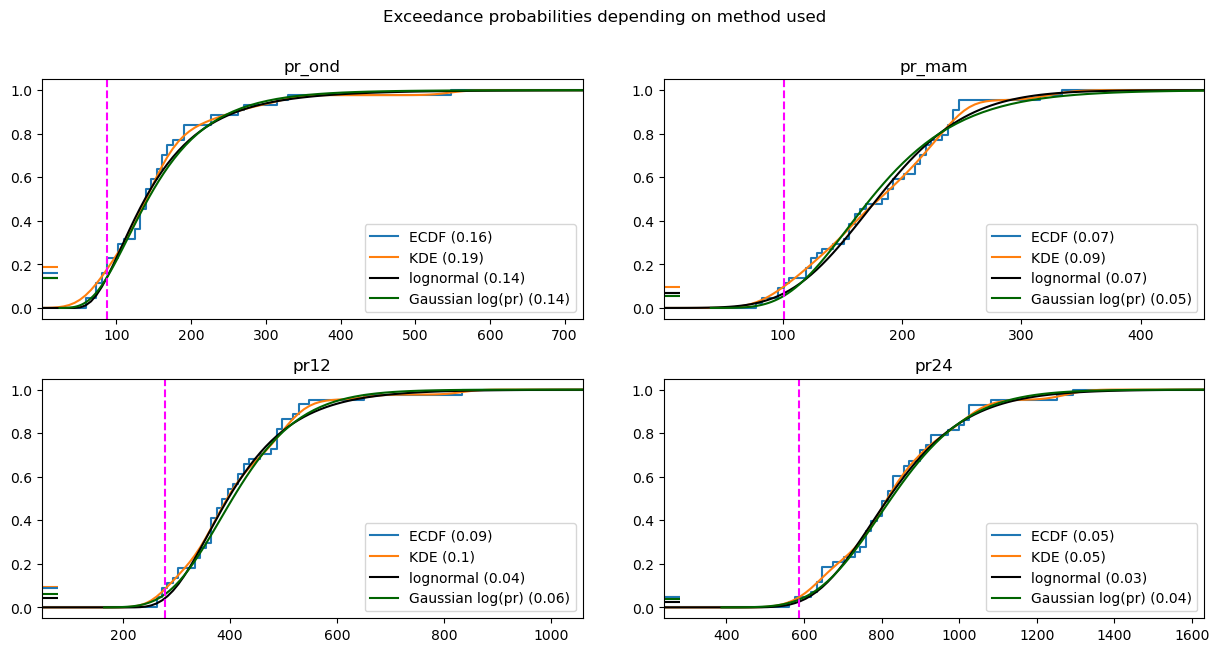

In [88]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (15,7), dpi = 100)
plt.subplots_adjust(wspace = 0.15, hspace = 0.25)
kde_bw = 0.25

for i in range(4):
    varnm = ["pr_ond", "pr_mam", "pr12", "pr24"][i]
    ax = plt.gcf().axes[i]
    
    # get x & y values for fitting & plotting
    y = df[varnm].dropna()
    x = np.linspace(max(y.min() - y.std() * 2, 0.1), y.max() + y.std() * 2, 100)
    logy = np.log(y)
    logx = np.linspace(logy.min() - logy.std() * 2, logy.max() + logy.std() * 2, 100)
    
    lnorm_fit = lognorm.fit(y, 0.5, loc = np.log(y).mean())
    norm_fit = norm.fit(logy)
        
    ep_kde = kde_ep(y, y[2022], bw_method = kde_bw)
    ep_ecdf = ecdf_ep(y, y[2022])
    ep_lognorm = lognorm.cdf(y[2022], *lnorm_fit)
    ep_norm_logpr = norm.cdf(logy[2022], *norm.fit(logy))
    
    ax.step(x, ecdf(y)(x), label = "ECDF ("+str(ep_ecdf.round(2))+")")
    ax.plot(x, (kde(y, bw_method = kde_bw)(x) / kde(y, bw_method = kde_bw)(x).sum()).cumsum(), label = "KDE ("+str(ep_kde.round(2))+")")
    ax.plot(x, lognorm.cdf(x, *lnorm_fit), color = "k", label = "lognormal ("+str(ep_lognorm.round(2))+")")
    ax.plot(np.exp(logx), norm.cdf(logx, *norm.fit(logy)), color = "darkgreen", label = "Gaussian log(pr) ("+str(ep_norm_logpr.round(2))+")")
    ax.axvline(y[2022], color = "magenta", ls = "dashed")
    
    
    ax.scatter(x[0], ep_kde, marker = "_", s = 500, color = "tab:orange")
    ax.scatter(x[0], ep_ecdf, marker = "_", s = 500, color = "tab:blue")
    ax.scatter(x[0], ep_lognorm, marker = "_", s = 500, color = "k")
    ax.scatter(x[0], ep_norm_logpr, marker = "_", s = 500, color = "darkgreen")
    
    ax.set_title(varnm)
    ax.legend(loc = "lower right")
    ax.set_xlim(x.min(), x.max())
    
plt.suptitle("Exceedance probabilities depending on method used")

---
### **Nonstationary trends**

In [90]:
# load data, add column for constant (needed for statsmodels fitting)
df = pd.merge(reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'inner'),
                                     [pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year"),
                                      pd.read_csv("data/nino3.4rel_mam.csv", names = ["year", "nino_mam"], index_col = 0, skiprows = 1),
                                      pd.read_csv("data/nino3.4rel_ond.csv", names = ["year", "nino_ond"], index_col = 0, skiprows = 1),
                                      pd.read_csv("ts/EA-drought_pr-mam_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr_mam"], index_col = 0),
                                      pd.read_csv("ts/EA-drought_pr-ond_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr_ond"], index_col = 0),
                                      pd.read_csv("ts/EA-drought_pr12_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr12"], index_col = 0)]),
                              pd.read_csv("ts/EA-drought_pr24_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr24"], index_col = 0), left_index = True, right_index = True, how = "outer")

for varnm in ["pr_ond", "pr_mam", "pr12", "pr24"]: df["log_"+varnm] = np.log(df[varnm])
event_value = df.loc[2022]

In [8]:
# custom fitting method is going to be needed to fit fixed-dispersion model with both GMST and Nino3.4 as covariates
# for now, check effect of GMST & Nino3.4 separately

Text(0.5, 1.0, 'log_pr12 ~ nino_ond')

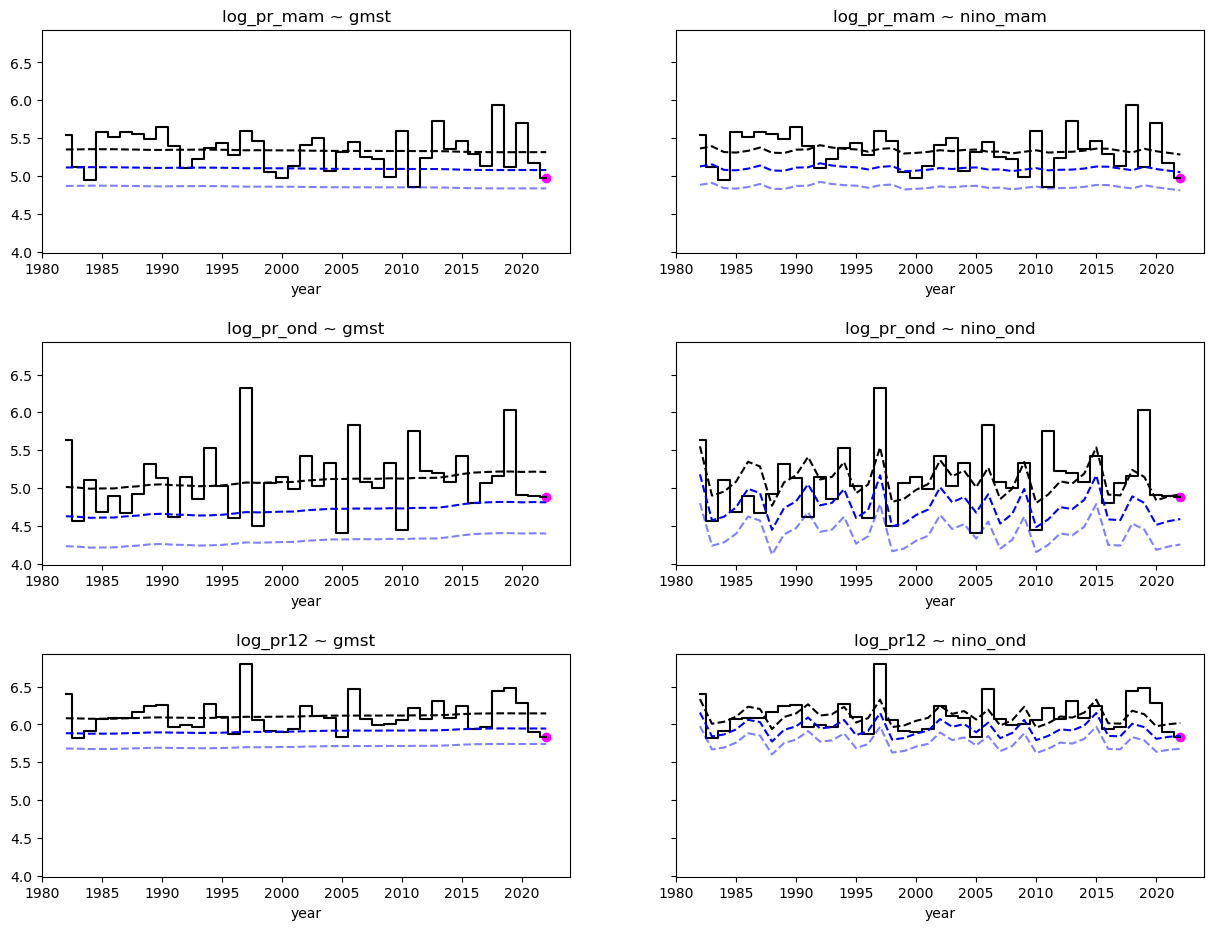

In [98]:
fig, axs = plt.subplots(ncols = 2, nrows = 3, figsize = (15,11), dpi = 100, sharey = True)
plt.subplots_adjust(hspace = 0.4)

time_trendplot(ns_fit(norm, "fixeddisp", df, "gmst", "log_pr_ond"), lower = True, ax = axs[1,0]); axs[1,0].set_title("log_pr_ond ~ gmst")
time_trendplot(ns_fit(norm, "fixeddisp", df, "nino_ond", "log_pr_ond"), lower = True, ax = axs[1,1]); axs[1,1].set_title("log_pr_ond ~ nino_ond")

time_trendplot(ns_fit(norm, "fixeddisp", df, "gmst", "log_pr_mam"), lower = True, ax = axs[0,0]); axs[0,0].set_title("log_pr_mam ~ gmst")
time_trendplot(ns_fit(norm, "fixeddisp", df, "nino_mam", "log_pr_mam"), lower = True, ax = axs[0,1]); axs[0,1].set_title("log_pr_mam ~ nino_mam")

time_trendplot(ns_fit(norm, "fixeddisp", df, "gmst", "log_pr12"), lower = True, ax = axs[2,0]); axs[2,0].set_title("log_pr12 ~ gmst")
time_trendplot(ns_fit(norm, "fixeddisp", df, "nino_ond", "log_pr12"), lower = True, ax = axs[2,1]); axs[2,1].set_title("log_pr12 ~ nino_ond")

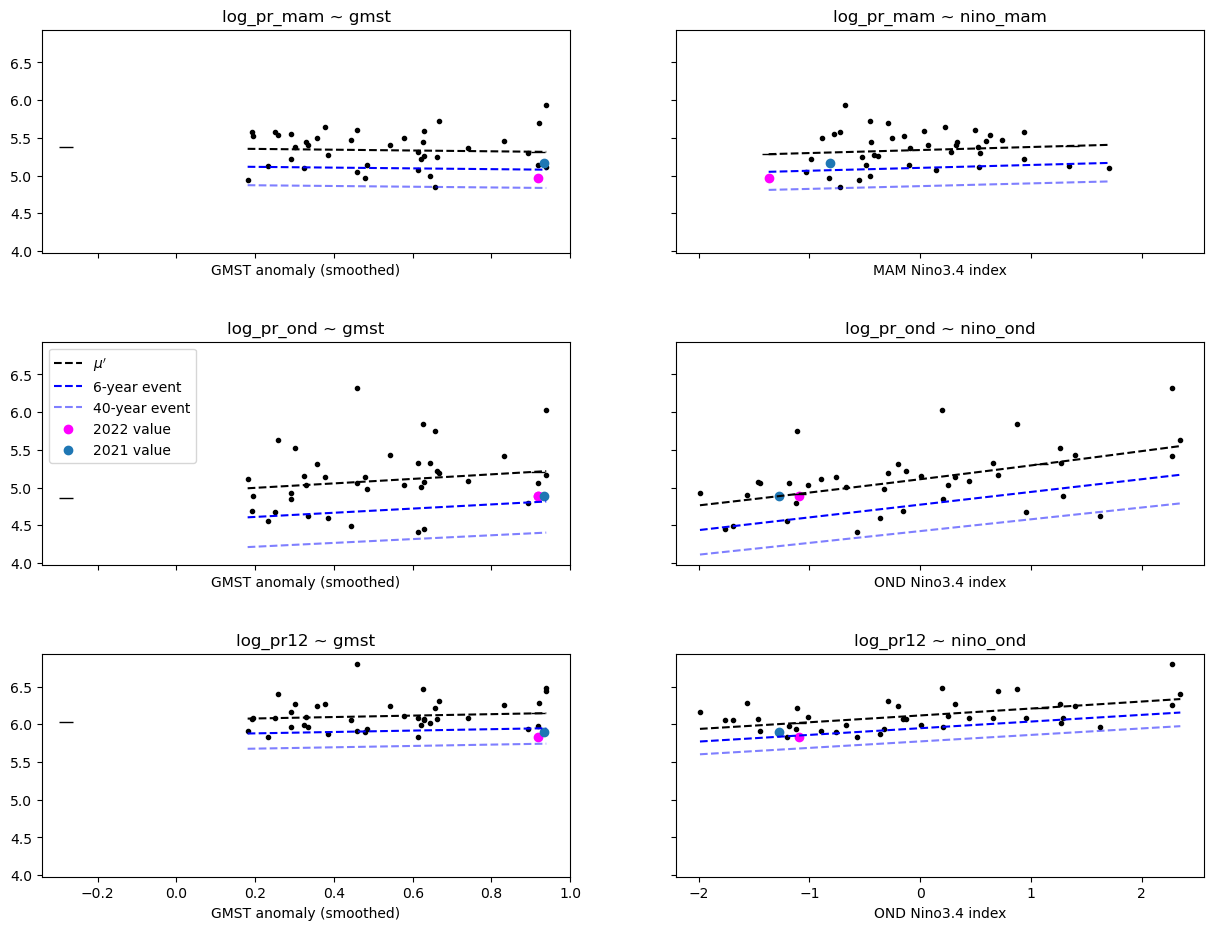

In [100]:
fig, axs = plt.subplots(ncols = 2, nrows = 3, figsize = (15,11), dpi = 100, sharey = True, sharex = "col")
plt.subplots_adjust(hspace = 0.4)

trendplot(ns_fit(norm, "fixeddisp", df, "gmst", "log_pr_ond"), cov1 = event_value.gmst, cov2 = event_value.gmst - 1.2, lower = True, ax = axs[1,0])
axs[1,0].scatter(df.loc[2022, "gmst"], df.loc[2022, "log_pr_ond"], color = "magenta", label = "2022 value")
axs[1,0].scatter(df.loc[2021, "gmst"], df.loc[2021, "log_pr_ond"], label = "2021 value")
axs[1,0].set_title("log_pr_ond ~ gmst")
axs[1,0].legend()

trendplot(ns_fit(norm, "fixeddisp", df, "nino_ond", "log_pr_ond"), cov1 = event_value.nino_ond, cov2 = event_value.nino_ond * -1, lower = True, ax = axs[1,1])
axs[1,1].scatter(df.loc[2021, "nino_ond"], df.loc[2021, "log_pr_ond"])
axs[1,1].set_title("log_pr_ond ~ nino_ond")
axs[1,1].set_xlabel("OND Nino3.4 index")

trendplot(ns_fit(norm, "fixeddisp", df, "gmst", "log_pr_mam"), cov1 = event_value.gmst, cov2 = event_value.gmst - 1.2, lower = True, ax = axs[0,0])
axs[0,0].scatter(df.loc[2021, "gmst"], df.loc[2021, "log_pr_mam"])
axs[0,0].set_title("log_pr_mam ~ gmst")

trendplot(ns_fit(norm, "fixeddisp", df, "nino_mam", "log_pr_mam"), cov1 = event_value.nino_mam, cov2 = event_value.nino_mam *-1, lower = True, ax = axs[0,1]); axs[0,1].set_title("log_pr_mam ~ nino_mam")
axs[0,1].scatter(df.loc[2021, "nino_mam"], df.loc[2021, "log_pr_mam"])
axs[0,1].set_xlabel("MAM Nino3.4 index")

trendplot(ns_fit(norm, "fixeddisp", df, "gmst", "log_pr12"), cov1 = event_value.gmst, cov2 = event_value.gmst - 1.2, lower = True, ax = axs[2,0])
axs[2,0].scatter(df.loc[2021, "gmst"], df.loc[2021, "log_pr12"])
axs[2,0].set_title("log_pr12 ~ gmst")

trendplot(ns_fit(norm, "fixeddisp", df, "nino_ond", "log_pr12"), cov1 = event_value.nino_ond, cov2 = event_value.nino_ond * -1, lower = True, ax = axs[2,1]); axs[2,1].set_title("log_pr12 ~ nino_ond")
axs[2,1].scatter(df.loc[2021, "nino_ond"], df.loc[2021, "log_pr12"])
axs[2,1].set_xlabel("OND Nino3.4 index")

plt.savefig("fig/trends-vs-gmst-and-nino34.png")

Difference between Nino3.4 index of 1.1 and -1.1:  200.52825316603264%



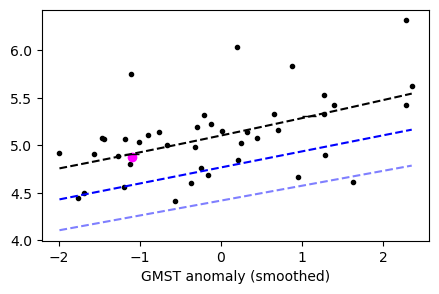

In [96]:
# what does this mean in terms of actual precip?
mdl = ns_fit(norm, "fixeddisp", df[["nino_ond", "log_pr_ond"]], "nino_ond", "log_pr_ond")
trendplot(mdl, cov1 = event_value.nino_ond, cov2 = event_value.nino_ond * -1, lower = True); axs[0,1].set_title("log_pr_ond ~ nino_ond")

print("Difference between Nino3.4 index of 1.1 and -1.1: ", str((np.exp(ns_pars(mdl, 1.1)["loc"]) - np.exp(ns_pars(mdl, -1.1)["loc"])/np.exp(ns_pars(mdl, -1.1)["loc"])))+"%")
print()

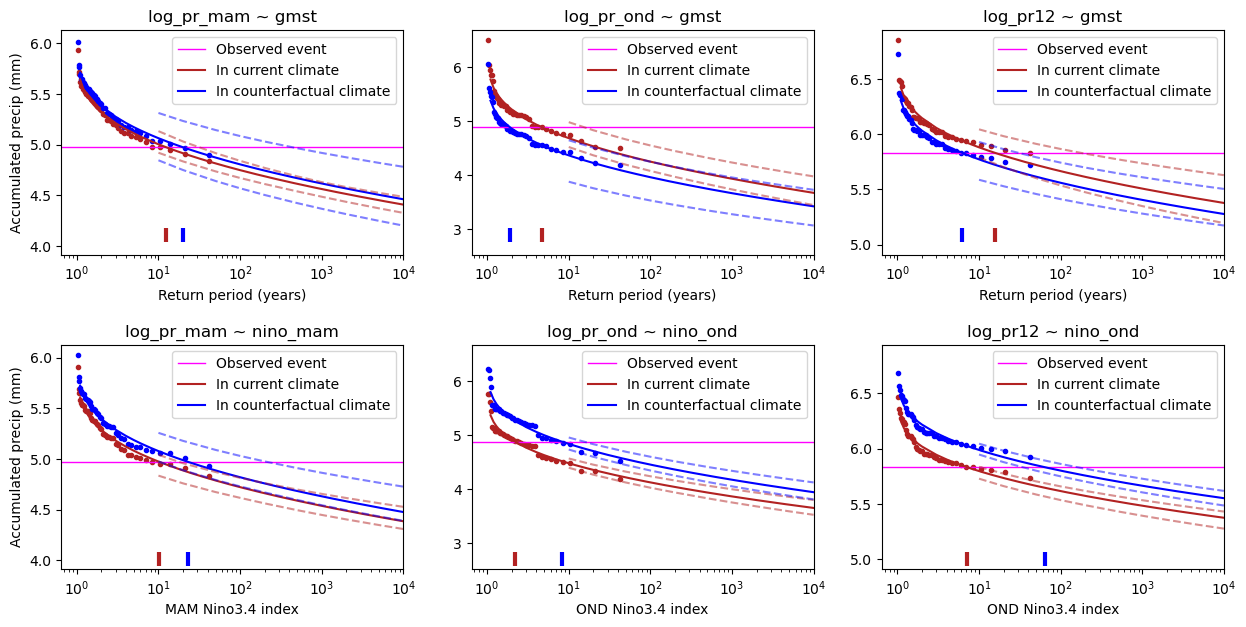

In [27]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (15,7), dpi = 100, sharey = "col")
plt.subplots_adjust(hspace = 0.4)

for i in range(3):
    varnm = ["log_pr_mam", "log_pr_ond", "log_pr12"][i]
    
    rlplot(ns_fit(norm, "fixeddisp", df, "gmst", varnm), cov1 = event_value.gmst, cov2 = event_value.gmst - 1.2, event_value = event_value[varnm], lower = True, ax = axs[0,i]); axs[0,i].set_title(varnm+" ~ gmst")
    
rlplot(ns_fit(norm, "fixeddisp", df, "nino_mam", "log_pr_mam"), cov1 = event_value.nino_mam, cov2 = event_value.nino_mam *-1, event_value = event_value.log_pr_mam, lower = True, ax = axs[1,0]); axs[1,0].set_title("log_pr_mam ~ nino_mam")
rlplot(ns_fit(norm, "fixeddisp", df, "nino_ond", "log_pr_ond"), cov1 = event_value.nino_ond, cov2 = event_value.nino_ond *-1, event_value = event_value.log_pr_ond, lower = True, ax = axs[1,1]); axs[1,1].set_title("log_pr_ond ~ nino_ond")
rlplot(ns_fit(norm, "fixeddisp", df, "nino_ond", "log_pr12"), cov1 = event_value.nino_ond, cov2 = event_value.nino_ond *-1, event_value = event_value.log_pr12, lower = True, ax = axs[1,2]); axs[1,2].set_title("log_pr12 ~ nino_ond")

for ax in axs[:,0]: ax.set_ylabel("Accumulated precip (mm)")

axs[1,0].set_xlabel("MAM Nino3.4 index")
for ax in axs[1,1:]: ax.set_xlabel("OND Nino3.4 index")


#### **Check of other possible covariates**

In [22]:
# Indian Ocean Dipole: possible compounding effect on short rains in La Nina years?
iod = decode_times(xr.open_dataset("../../Data/ihadisst1_dmi.nc", decode_times = False))["diff"]

iod_mam = iod.sel(time = [m in [3,4,5] for m in iod.time.dt.month]).resample(time = "AS-JAN").mean()
iod_mam = iod_mam.assign_coords(time = iod_mam.time.dt.year).rename("iod_mam", time = "year")
iod_mam.to_dataframe().to_csv("data/iod_mam.csv")

iod_ond = iod.sel(time = [m in [10,11,12] for m in iod.time.dt.month]).resample(time = "AS-JAN").mean()
iod_ond = iod_ond.assign_coords(time = iod_ond.time.dt.year).rename("iod_ond", time = "year")
iod_ond.to_dataframe().to_csv("data/iod_ond.csv")

In [70]:
mjo_mam = []
mjo_ond = []

for i in range(10):
    i = str(i+1).rjust(2,"0")
    mjo = decode_times(xr.open_dataset("../../Data/MJO/icpc_mjo"+i+"_mean12.nc", decode_times = False)["index"]).rename("mjo"+i)
    
    mam = mjo.sel(time = [m in [3,4,5] for m in mjo.time.dt.month]).resample(time = "AS-JAN").mean()
    mam = mam.assign_coords(time = mam.time.dt.year).rename(mam.name+"_mam", time = "year")
    mjo_mam.append(mam)
    
    ond = mjo.sel(time = [m in [10,11,12] for m in mjo.time.dt.month]).resample(time = "AS-JAN").mean()
    ond = ond.assign_coords(time = ond.time.dt.year).rename(ond.name+"_ond", time = "year")
    mjo_ond.append(ond)

xr.merge(mjo_mam).to_dataframe().to_csv("data/mjo_mam.csv")
xr.merge(mjo_ond).to_dataframe().to_csv("data/mjo_ond.csv")

In [19]:
# load data, including assorted indices
df = pd.merge(pd.merge(reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'inner'),
                              [pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year"),
                               pd.read_csv("data/nino3.4rel_mam.csv", names = ["year", "nino_mam"], index_col = 0, skiprows = 1),
                               pd.read_csv("data/nino3.4rel_ond.csv", names = ["year", "nino_ond"], index_col = 0, skiprows = 1),
                               pd.read_csv("ts/EA-drought_pr-mam_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr_mam"], index_col = 0),
                               pd.read_csv("ts/EA-drought_pr-ond_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr_ond"], index_col = 0),
                               pd.read_csv("ts/EA-drought_pr12_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr12"], index_col = 0),
                               pd.read_csv("data/iod_mam.csv", index_col = 0), pd.read_csv("data/iod_ond.csv", index_col = 0),
                              ]),
                       pd.read_csv("ts/EA-drought_pr24_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr24"], index_col = 0), left_index = True, right_index = True, how = "outer"),
              pd.merge(pd.read_csv("data/mjo_mam.csv", index_col = 0), pd.read_csv("data/mjo_ond.csv", index_col = 0), left_index = True, right_index = True), left_index = True, right_index = True, how = "left")

df["log_pr_ond"] = np.log(df.pr_ond)
df["log_pr_mam"] = np.log(df.pr_mam)

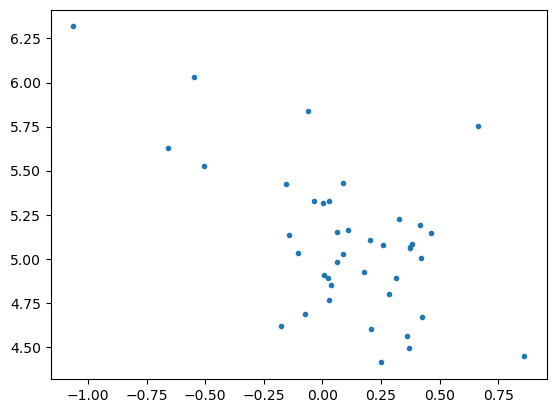

In [87]:
plt.scatter(df.mjo09_ond, df.log_pr_ond, marker = ".")

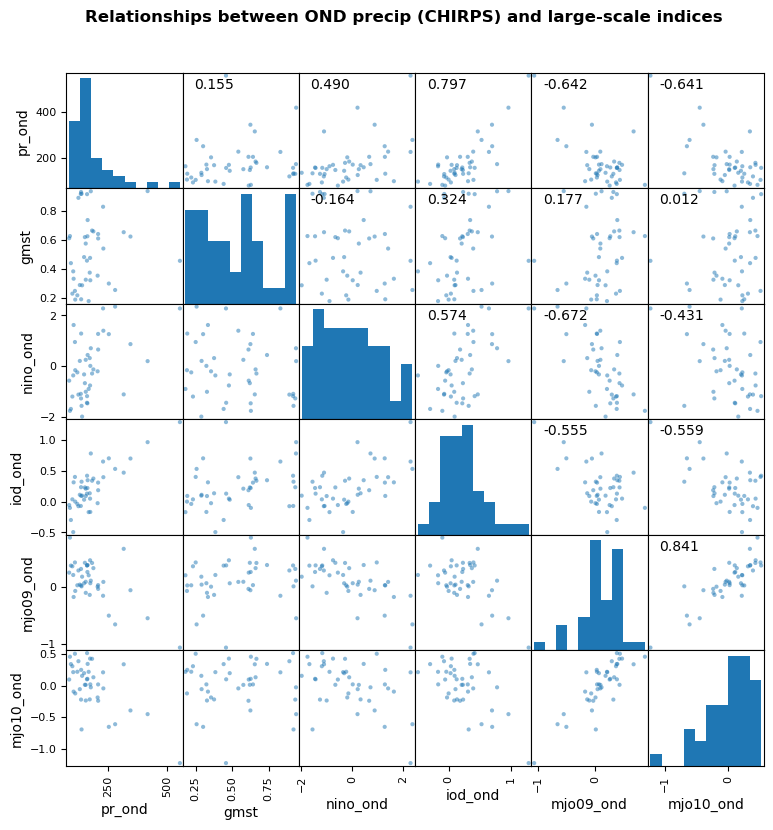

In [89]:
pred = "pr_ond"
s = "ond"
df_ond = df[[pred, "gmst", "nino_"+s, "iod_"+s, "mjo09_"+s, "mjo10_"+s]]
axs = pd.plotting.scatter_matrix(df_ond, alpha=0.5, figsize=(9,9), diagonal='hist', marker='.', range_padding=0.05)

corr = df_ond.corr().to_numpy()
for i, j in zip(*plt.np.triu_indices_from(axs, k=1)):
    axs[i, j].annotate("%.3f" %corr[i,j], (0.1, 0.9), xycoords='axes fraction', ha='left', va='center')

plt.suptitle("Relationships between OND precip (CHIRPS) and large-scale indices", y = 0.95, fontweight = "bold")
plt.savefig("fig/ond_relationships.png")

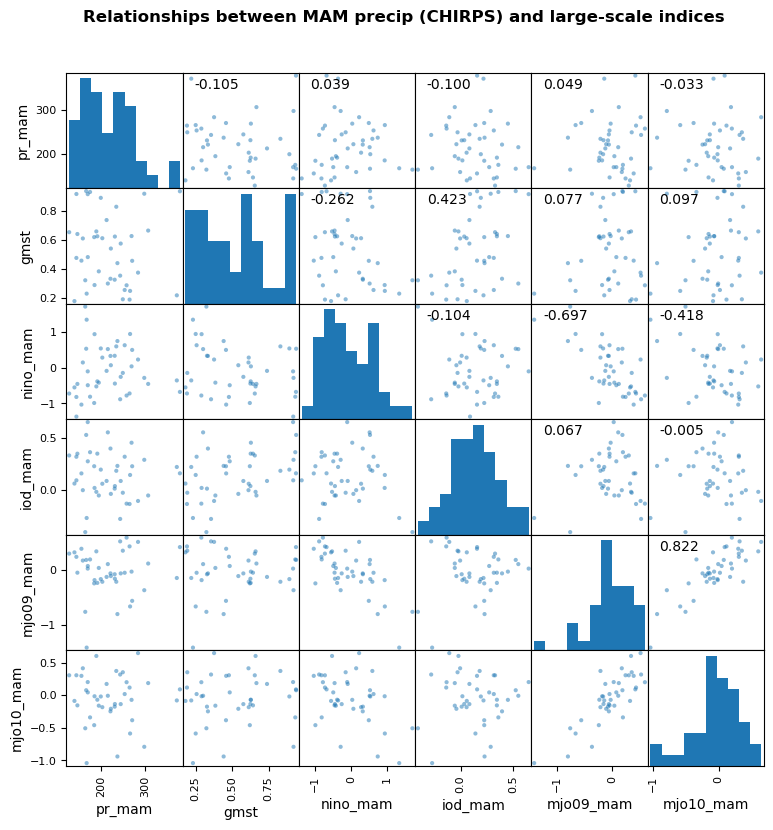

In [90]:
pred = "pr_mam"
s = "mam"
df_ond = df[[pred, "gmst", "nino_"+s, "iod_"+s, "mjo09_"+s, "mjo10_"+s]]
axs = pd.plotting.scatter_matrix(df_ond, alpha=0.5, figsize=(9,9), diagonal='hist', marker='.', range_padding=0.05)

corr = df_ond.corr().to_numpy()
for i, j in zip(*plt.np.triu_indices_from(axs, k=1)):
    axs[i, j].annotate("%.3f" %corr[i,j], (0.1, 0.9), xycoords='axes fraction', ha='left', va='center')

plt.title("")

plt.suptitle("Relationships between MAM precip (CHIRPS) and large-scale indices", y = 0.95, fontweight = "bold")
plt.savefig("fig/mam_relationships.png")

In [20]:
pd.DataFrame({c : model_results(ns_fit(norm, "fixeddisp", df, c, "log_pr_ond"), df.loc[2022, "gmst"], df.loc[1981, "gmst"]) for c in ["gmst"] + [c for c in df.columns if "ond" in c and not "pr" in c]}).transpose().dropna(axis = 1, how = "all")

mu     sigma     alpha      loc1    scale1     disp1  \
gmst       4.915308  0.392229  0.347150  5.244981  0.418536  0.079797   
nino_ond   5.111917  0.357049  0.178600  5.278745  0.368702  0.069846   
iod_ond    4.877751  0.249258  0.872492  5.749409  0.293800  0.051101   
mjo01_ond  5.044199  0.370528 -0.541491  4.570246  0.335713  0.073456   
mjo02_ond  5.140747  0.413668  0.206592  5.334190  0.429234  0.080468   
mjo03_ond  5.171453  0.392204  0.455311  5.607360  0.425264  0.075840   
mjo04_ond  5.182437  0.343476  0.646288  5.811869  0.385192  0.066277   
mjo05_ond  5.137186  0.326289  0.666644  5.787985  0.367624  0.063515   
mjo06_ond  5.076687  0.349234  0.585242  5.644156  0.388271  0.068792   
mjo07_ond  5.077666  0.409656  0.185329  5.250904  0.423633  0.080678   
mjo08_ond  5.180234  0.385491 -0.502417  4.738416  0.352613  0.074416   
mjo09_ond  5.164959  0.337870 -0.658357  4.593924  0.300515  0.065416   
mjo10_ond  5.103905  0.335655 -0.625979  4.559773  0.299870  0.065764   

               loc2    scale2     disp2        nll  
gmst       4.992498  0.398388  0.079797  20.820361  
nino_ond   5.151473  0.359812  0.069846  15.463600  
iod_ond    5.074093  0.259291  0.051101   2.920874  
mjo01_ond  4.926136  0.361855  0.073456  17.490570  
mjo02_ond  5.186529  0.417352  0.080468  21.156651  
mjo03_ond  5.272888  0.399897  0.075840  18.770836  
mjo04_ond  5.327004  0.353057  0.066277  13.353713  
mjo05_ond  5.286390  0.335765  0.063515  11.647894  
mjo06_ond  5.207462  0.358230  0.068792  14.855881  
mjo07_ond  5.118719  0.412968  0.080678  21.259945  
mjo08_ond  5.070566  0.377330  0.074416  18.009901  
mjo09_ond  5.021732  0.328501  0.065416  12.830558  
mjo10_ond  4.967650  0.326694  0.065764  13.045255

In [46]:
df_ond.corr()

<AxesSubplot: xlabel='year'>

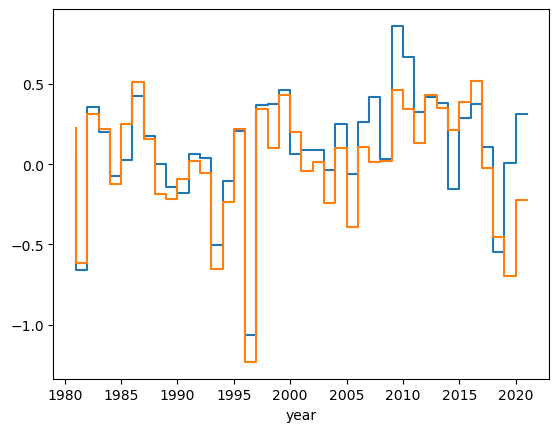

In [48]:
df.mjo09_ond.plot(drawstyle = "steps")
df.mjo10_ond.plot(drawstyle = "steps")

### **Least squares fitting with Nino & GMST as covariates**

https://realpython.com/linear-regression-in-python/#advanced-linear-regression-with-statsmodels

In [4]:
import statsmodels.api as sm

# load data, add column for constant (needed for statsmodels fitting)
df = pd.merge(reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'inner'),
                                     [pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year"),
                                      pd.read_csv("data/nino3.4rel_mam.csv", names = ["year", "nino_mam"], index_col = 0, skiprows = 1),
                                      pd.read_csv("data/nino3.4rel_ond.csv", names = ["year", "nino_ond"], index_col = 0, skiprows = 1),
                                      pd.read_csv("ts/EA-drought_pr-mam_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr_mam"], index_col = 0),
                                      pd.read_csv("ts/EA-drought_pr-ond_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr_ond"], index_col = 0),
                                      pd.read_csv("ts/EA-drought_pr12_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr12"], index_col = 0)]),
                              pd.read_csv("ts/EA-drought_pr24_chirps05.dat", comment = "#", sep = " ", names = ["year", "pr24"], index_col = 0), left_index = True, right_index = True, how = "outer")

df = sm.add_constant(df)
df["nino_pos"] = 1; df["nino_neg"] = -1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def lnorm_trendplot(mdl, ax = None, show_fitted = False):
    
    if not ax:
        fig, ax = plt.subplots(ncols = 1, figsize = (6,4), dpi = 100)
        
    nino_effect = ["nino" in n for n in mdl.data.xnames]
    if any(nino_effect):
        col_args = {"c" : mdl.data.exog[:,["nino" in n for n in mdl.data.xnames]], "cmap" : "RdBu", "vmin" : -1.5, "vmax" : 1.5}
    else:
        col_args = {"color" : "k"}
    
    cbar = ax.scatter(mdl.data.row_labels, mdl.data.endog, **col_args, marker = "o")
        
    if any(nino_effect):
        ax.plot(mdl.fit().predict(df[[re.sub("_.+", "_pos", m) if "nino" in m else m for m in mdl.data.xnames]]), label = "Nino3.4 = 1", ls = "--")
        ax.plot(mdl.fit().predict(df[[re.sub("_.+", "_neg", m) if "nino" in m else m for m in mdl.data.xnames]]), color = "darkred", label = "Nino3.4 = -1", ls = "--")
    else:
        ax.plot(mdl.fit().predict(df[mdl.data.xnames]), label = "Fitted trend", color = "k", alpha = 0.5, ls = "--")
    
    if show_fitted:
        [ax.plot(np.repeat(mdl.data.row_labels[i], 2), [mdl.data.endog[i], mdl.fit().fittedvalues.iloc[i]], color = "k", alpha = 0.2) for i in range(len(df))]
        ax.scatter(mdl.data.row_labels, mdl.fit().fittedvalues, **col_args, marker = "x", label = "Fitted values")
        
    ax.set_title(mdl.data.ynames+" ~ "+" + ".join(mdl.data.xnames))
    ax.legend()
    ax.set_ylabel("Accumulated precip (mm)")
    
    return cbar
    
    

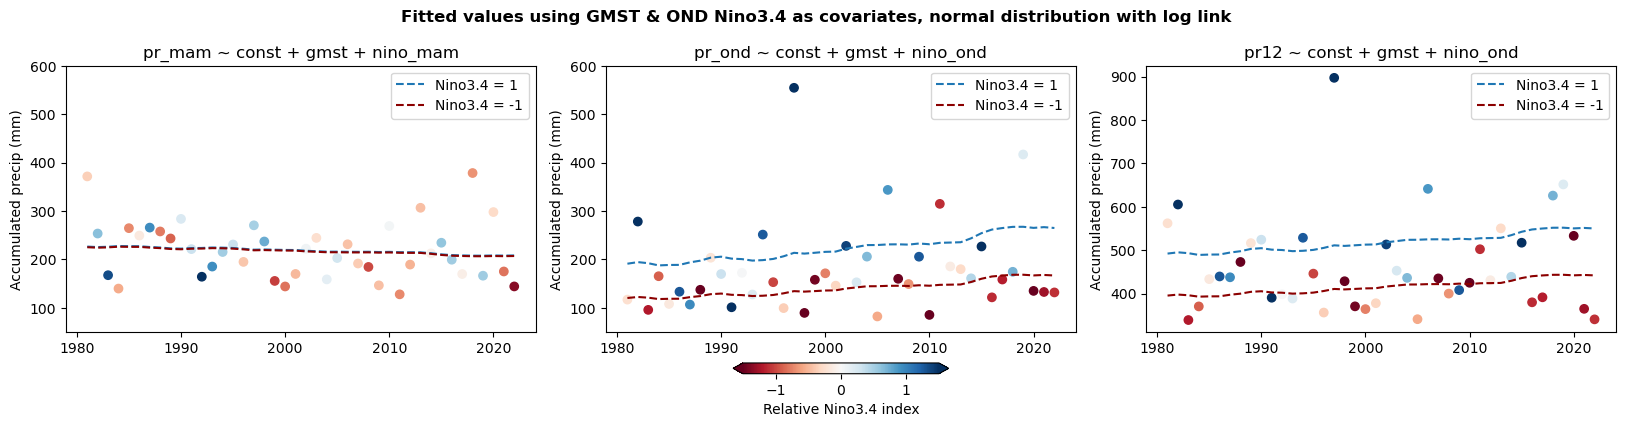

In [5]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (20,4), dpi = 100)
plt.subplots_adjust(wspace = 0.15, hspace = 0.35)

lnorm_trendplot(sm.GLM(df[["pr_mam"]], df[["const", "gmst", "nino_mam"]], family=sm.families.Gaussian(link = sm.families.links.log())), ax = axs[0], show_fitted = False)
axs[0].set_ylim(50,600)
lnorm_trendplot(sm.GLM(df[["pr_ond"]], df[["const", "gmst", "nino_ond"]], family=sm.families.Gaussian(link = sm.families.links.log())), ax = axs[1], show_fitted = False)
axs[1].set_ylim(50,600)
cbar = lnorm_trendplot(sm.GLM(df[["pr12"]], df[["const", "gmst", "nino_ond"]], family=sm.families.Gaussian(link = sm.families.links.log())), ax = axs[2], show_fitted = False)

plt.suptitle("Fitted values using GMST & OND Nino3.4 as covariates, normal distribution with log link", fontweight = "bold", y = 1.02)
plt.colorbar(cbar, ax = axs, location = "bottom", shrink = 1, fraction = 0.035, pad = 0.1, label = "Relative Nino3.4 index", extend = "both")

In [6]:
# load data - use very skewed precip data
df = pd.merge(pd.read_csv("ts/EA-drought_pet-ond_cpc.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","pet"], index_col = "year"),
              pd.read_csv("ts/EA-drought_tas-ond_cpc.dat", comment = "#", sep = " ", names = ["year", "tas"], index_col = 0),
              left_index = True, right_index = True)

In [116]:
xr.open_dataset("../../Data/cvdp_cmip5/HadGEM2-ES_1.cvdp_data.2006-2100.nc", decode_times = False)

<xarray.Dataset>
Dimensions:                         (TIME: 95, lat: 145, lon: 192, ncurves: 4,
                                     frequency: 570, time: 1140, longitude: 86,
                                     time_mon3: 49, time_mon1: 29,
                                     time_mon2: 12, period: 122)
Coordinates:
  * TIME                            (TIME) int32 2006 2007 2008 ... 2099 2100
  * frequency                       (frequency) float32 0.0008772 ... 0.5
  * lat                             (lat) float64 -90.0 -88.75 ... 88.75 90.0
  * lon                             (lon) float64 0.0 1.875 3.75 ... 356.2 358.1
  * longitude                       (longitude) float64 120.0 121.9 ... 279.4
  * ncurves                         (ncurves) int32 0 1 2 3
  * period                          (period) float32 0.08609 0.09121 ... 93.39
  * time                            (time) float64 0.0 1.0 ... 1.139e+03
  * time_mon1                       (time_mon1) int32 0 1 2 3 4 ... 25 26 27 28
  * time_mon2                       (time_mon2) int32 0 1 2 3 4 5 6 7 8 9 10 11
  * time_mon3                       (time_mon3) int32 0 1 2 3 4 ... 45 46 47 48
Data variables: (12/323)
    amo_pattern_lowpass_mon         (lat, lon) float32 ...
    amo_pattern_mon                 (lat, lon) float32 ...
    amo_pr_regression_lowpass_mon   (lat, lon) float32 ...
    amo_pr_regression_mon           (lat, lon) float32 ...
    amo_spectra                     (ncurves, frequency) float32 ...
    amo_tas_regression_lowpass_mon  (lat, lon) float32 ...
    ...                              ...
    tas_trends_djf                  (lat, lon) float32 ...
    tas_trends_jja                  (lat, lon) float32 ...
    tas_trends_mam                  (lat, lon) float32 ...
    tas_trends_mon                  (lat, lon) float32 ...
    tas_trends_son                  (lat, lon) float32 ...
    tropical_indian_ocean           (time) float32 ...
Attributes:
    source:       NCAR Climate Analysis Section's Climate Variability Diagnos...
    notes:        Data from HadGEM2-ES_1 from 2006-2100
    climatology:  2006-2100 climatology removed prior to all calculations (ot...
    Conventions:  CF-1.6
    history:      Tue Nov  5 03:23:59 2019: ncks -O /project/diagnostics/exte...
    NCO:          "4.5.2"